In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, ConcatDataset, SubsetRandomSampler, DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math
import pickle

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from torchvision.models import vgg16_bn
from torchvision import models

In [2]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_dict={0: 'airplanes', 1: 'cars', 2: 'birds', 3: 'cats', 4: 'deer', 5: 'dogs', 6: 'frogs',7: 'horses', 8: 'ships', 9: 'trucks'}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, tsne_features


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

## ExpLoss

In [9]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
    
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

## sVGG

In [25]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes, residual=True):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.exploss = ExpLoss(512, residual=residual)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

# CIFAR10

> The test accuracy is 0.9924 > 0.9903 of the SOTA model training from scratch

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = datasets.CIFAR10(root='/tf/data/benchmark_datasets/cifar10', train=True, download=False, 
                            transform=train_transforms)

test_set = datasets.CIFAR10(root='/tf/data/benchmark_datasets/cifar10', train=False, download=False, 
                            transform=test_transforms)

In [6]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)


In [7]:
# create model
device = torch.device('cuda')
lr = 0.001
model = sVGG_exp(features=vgg16_bn(pretrained=False).features[:34], in_features_classifier=512, n_classes=10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

In [8]:
model_path = 'exploss_benchmarks/resExploss_CIFAR10_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=1.5189995765686035 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:15<00:00, 12.26it/s]     

- Avg.loss: 0.8619 | Avg.acc: 0.6299


- Avg. test_loss: 1.5549 | Avg. test_acc: 0.4726


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.418817162513733 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:16<00:00, 12.25it/s]      

- Avg.loss: 0.4584 | Avg.acc: 0.8041


- Avg. test_loss: 0.7657 | Avg. test_acc: 0.8024


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.8813793063163757 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:16<00:00, 12.15it/s]        

- Avg.loss: 0.3314 | Avg.acc: 0.8578



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.0591 | Avg. test_acc: 0.7125
Epoch:  4


Loss=0.6732195019721985 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:16<00:00, 12.20it/s]     

- Avg.loss: 0.3271 | Avg.acc: 0.8690



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.4680 | Avg. test_acc: 0.5696
Epoch:  5


Loss=1.8132803440093994 Batch_id=195 Accuracy=0.4125: 100%|██████████| 196/196 [00:15<00:00, 12.25it/s]     

- Avg.loss: 0.2621 | Avg.acc: 0.9068


- Avg. test_loss: 0.6181 | Avg. test_acc: 0.8452


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.19783619046211243 Batch_id=195 Accuracy=0.925: 100%|██████████| 196/196 [00:16<00:00, 12.20it/s]      

- Avg.loss: 0.2438 | Avg.acc: 0.9065



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.8820 | Avg. test_acc: 0.7444
Epoch:  7


Loss=0.3892505168914795 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:16<00:00, 12.19it/s]     

- Avg.loss: 0.2458 | Avg.acc: 0.9224



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.8572 | Avg. test_acc: 0.6910
Epoch:  8


Loss=1.094092607498169 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:16<00:00, 12.12it/s]       

- Avg.loss: 0.1977 | Avg.acc: 0.9309



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1459 | Avg. test_acc: 0.7613
Epoch:  9


Loss=0.508808434009552 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]       

- Avg.loss: 0.1688 | Avg.acc: 0.9421



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 4.8291 | Avg. test_acc: 0.4917
Epoch:  10


Loss=0.6578108072280884 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:16<00:00, 12.15it/s]      

- Avg.loss: 0.1501 | Avg.acc: 0.9546


- Avg. test_loss: 0.2994 | Avg. test_acc: 0.9276


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.34727364778518677 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:16<00:00, 12.04it/s]      

- Avg.loss: 0.1483 | Avg.acc: 0.9556



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5468 | Avg. test_acc: 0.8445
Epoch:  12


Loss=1.7207591533660889 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:16<00:00, 12.17it/s]        

- Avg.loss: 0.1952 | Avg.acc: 0.9369



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.8228 | Avg. test_acc: 0.5740
Epoch:  13


Loss=0.08730490505695343 Batch_id=195 Accuracy=0.975: 100%|██████████| 196/196 [00:16<00:00, 12.17it/s]      

- Avg.loss: 0.1281 | Avg.acc: 0.9606


- Avg. test_loss: 0.0890 | Avg. test_acc: 0.9731


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.5409736037254333 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:16<00:00, 12.03it/s]      

- Avg.loss: 0.0890 | Avg.acc: 0.9717



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.8195 | Avg. test_acc: 0.6671
Epoch:  15


Loss=0.41840067505836487 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]     

- Avg.loss: 0.1298 | Avg.acc: 0.9615



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1619 | Avg. test_acc: 0.7937
Epoch:  16


Loss=0.4328973889350891 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:16<00:00, 12.13it/s]      

- Avg.loss: 0.1004 | Avg.acc: 0.9728



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4500 | Avg. test_acc: 0.8752
Epoch:  17


Loss=0.6419930458068848 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:16<00:00, 12.19it/s]       

- Avg.loss: 0.1365 | Avg.acc: 0.9628



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.2558 | Avg. test_acc: 0.9267
Epoch:  18


Loss=0.049824126064777374 Batch_id=195 Accuracy=0.9875: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]    

- Avg.loss: 0.1259 | Avg.acc: 0.9637



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.4084 | Avg. test_acc: 0.5706
Epoch:  19


Loss=0.5969326496124268 Batch_id=195 Accuracy=0.95: 100%|██████████| 196/196 [00:16<00:00, 12.09it/s]        

- Avg.loss: 0.0463 | Avg.acc: 0.9868



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.4888 | Avg. test_acc: 0.6703
Epoch    19: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  20


Loss=0.4842475354671478 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s]        

- Avg.loss: 0.0242 | Avg.acc: 0.9926


- Avg. test_loss: 0.0542 | Avg. test_acc: 0.9844


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.18261539936065674 Batch_id=195 Accuracy=0.925: 100%|██████████| 196/196 [00:16<00:00, 12.13it/s]      

- Avg.loss: 0.0120 | Avg.acc: 0.9971


- Avg. test_loss: 0.0401 | Avg. test_acc: 0.9898


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=0.5427881479263306 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]       

- Avg.loss: 0.0131 | Avg.acc: 0.9976



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0493 | Avg. test_acc: 0.9881
Epoch:  23


Loss=0.5196443200111389 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:16<00:00, 12.10it/s]      

- Avg.loss: 0.0178 | Avg.acc: 0.9942



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0437 | Avg. test_acc: 0.9843
Epoch:  24


Loss=0.2958987355232239 Batch_id=195 Accuracy=0.9375: 100%|██████████| 196/196 [00:16<00:00, 12.12it/s]       

- Avg.loss: 0.0103 | Avg.acc: 0.9971



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0392 | Avg. test_acc: 0.9891
Epoch:  25


Loss=1.5714643001556396 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:16<00:00, 12.09it/s]      

- Avg.loss: 0.0073 | Avg.acc: 0.9984



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0469 | Avg. test_acc: 0.9882
Epoch:  26


Loss=0.4727711081504822 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]      

- Avg.loss: 0.0109 | Avg.acc: 0.9967



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0466 | Avg. test_acc: 0.9890
Epoch:  27


Loss=0.9568619728088379 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:16<00:00, 12.08it/s]      

- Avg.loss: 0.0157 | Avg.acc: 0.9972



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0437 | Avg. test_acc: 0.9897
Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  28


Loss=0.021774111315608025 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.13it/s]       

- Avg.loss: 0.0077 | Avg.acc: 0.9975


- Avg. test_loss: 0.0433 | Avg. test_acc: 0.9900


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.002637273631989956 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]        

- Avg.loss: 0.0040 | Avg.acc: 0.9991



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0402 | Avg. test_acc: 0.9894
Epoch:  30


Loss=0.53240567445755 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]          

- Avg.loss: 0.0089 | Avg.acc: 0.9975



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0543 | Avg. test_acc: 0.9864
Epoch:  31


Loss=0.17204871773719788 Batch_id=195 Accuracy=0.975: 100%|██████████| 196/196 [00:16<00:00, 12.05it/s]      

- Avg.loss: 0.0050 | Avg.acc: 0.9989



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0457 | Avg. test_acc: 0.9882
Epoch:  32


Loss=0.06777031719684601 Batch_id=195 Accuracy=0.9875: 100%|██████████| 196/196 [00:16<00:00, 12.17it/s]    

- Avg.loss: 0.0031 | Avg.acc: 0.9993



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0440 | Avg. test_acc: 0.9849
Epoch:  33


Loss=0.009228247217833996 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]      

- Avg.loss: 0.0047 | Avg.acc: 0.9988



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0538 | Avg. test_acc: 0.9887
Epoch:  34


Loss=0.07205788046121597 Batch_id=195 Accuracy=0.975: 100%|██████████| 196/196 [00:16<00:00, 12.10it/s]     

- Avg.loss: 0.0073 | Avg.acc: 0.9981



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0414 | Avg. test_acc: 0.9876
Epoch    34: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  35


Loss=1.5326635837554932 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]      

- Avg.loss: 0.0114 | Avg.acc: 0.9976



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0537 | Avg. test_acc: 0.9863
Epoch:  36


Loss=0.021711021661758423 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]       

- Avg.loss: 0.0039 | Avg.acc: 0.9990



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0524 | Avg. test_acc: 0.9865
Epoch:  37


Loss=0.26095837354660034 Batch_id=195 Accuracy=0.925: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]      

- Avg.loss: 0.0065 | Avg.acc: 0.9981



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0533 | Avg. test_acc: 0.9863
Epoch:  38


Loss=1.0150415897369385 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:16<00:00, 12.17it/s]     

- Avg.loss: 0.0121 | Avg.acc: 0.9973



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0513 | Avg. test_acc: 0.9898
Epoch:  39


Loss=0.0018101183231920004 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.15it/s]      

- Avg.loss: 0.0044 | Avg.acc: 0.9990



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0432 | Avg. test_acc: 0.9886
Epoch:  40


Loss=0.02534109354019165 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]        

- Avg.loss: 0.0037 | Avg.acc: 0.9993



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0518 | Avg. test_acc: 0.9898
Epoch    40: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  41


Loss=0.01327961403876543 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.13it/s]        

- Avg.loss: 0.0095 | Avg.acc: 0.9977



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0456 | Avg. test_acc: 0.9885
Epoch:  42


Loss=0.5096876621246338 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]      

- Avg.loss: 0.0082 | Avg.acc: 0.9976



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0472 | Avg. test_acc: 0.9885
Epoch:  43


Loss=0.6235637068748474 Batch_id=195 Accuracy=0.9125: 100%|██████████| 196/196 [00:16<00:00, 12.08it/s]      

- Avg.loss: 0.0074 | Avg.acc: 0.9981



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0534 | Avg. test_acc: 0.9873
Epoch:  44


Loss=0.7910038232803345 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]      

- Avg.loss: 0.0069 | Avg.acc: 0.9984


- Avg. test_loss: 0.0514 | Avg. test_acc: 0.9906


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=0.00975994486361742 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]        

- Avg.loss: 0.0035 | Avg.acc: 0.9992



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0433 | Avg. test_acc: 0.9860
Epoch:  46


Loss=0.897977352142334 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:16<00:00, 12.13it/s]        

- Avg.loss: 0.0078 | Avg.acc: 0.9977



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0472 | Avg. test_acc: 0.9867
Epoch:  47


Loss=0.21457183361053467 Batch_id=195 Accuracy=0.9375: 100%|██████████| 196/196 [00:16<00:00, 12.04it/s]     

- Avg.loss: 0.0038 | Avg.acc: 0.9991


- Avg. test_loss: 0.0410 | Avg. test_acc: 0.9924


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  48


Loss=0.11998476833105087 Batch_id=195 Accuracy=0.925: 100%|██████████| 196/196 [00:16<00:00, 12.05it/s]     

- Avg.loss: 0.0043 | Avg.acc: 0.9991



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0427 | Avg. test_acc: 0.9909
Epoch:  49


Loss=1.0247161388397217 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:16<00:00, 12.07it/s]        

- Avg.loss: 0.0084 | Avg.acc: 0.9982



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.0444 | Avg. test_acc: 0.9899
Epoch:  50


Loss=0.0016681462293490767 Batch_id=195 Accuracy=1.0: 100%|██████████| 196/196 [00:16<00:00, 12.06it/s]     

- Avg.loss: 0.0069 | Avg.acc: 0.9987


- Avg. test_loss: 0.0513 | Avg. test_acc: 0.9870


In [9]:
pickle.dump(hist, open('exploss_benchmarks/resExploss_CIFAR10_hist.hdf5', 'wb'))

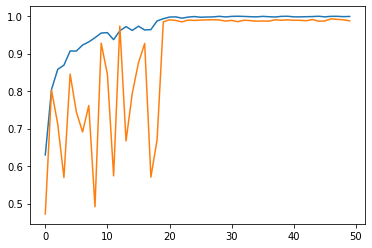

(0.9924, 0.040990106250415555)

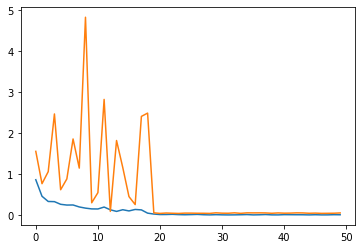

In [10]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])

best_acc, curloss

In [13]:
model = torch.load('exploss_benchmarks/resExploss_CIFAR10_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.0410 | Avg. val_acc: 0.9924


In [14]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([10000, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ 22.995497  ,  -4.593822  ],
        [-46.833244  , -73.98744   ],
        [-39.133114  , -72.89372   ],
        ...,
        [-79.99358   ,  -0.21336468],
        [ -1.3830891 ,   8.054836  ],
        [ -3.5980678 , -37.82426   ]], dtype=float32))

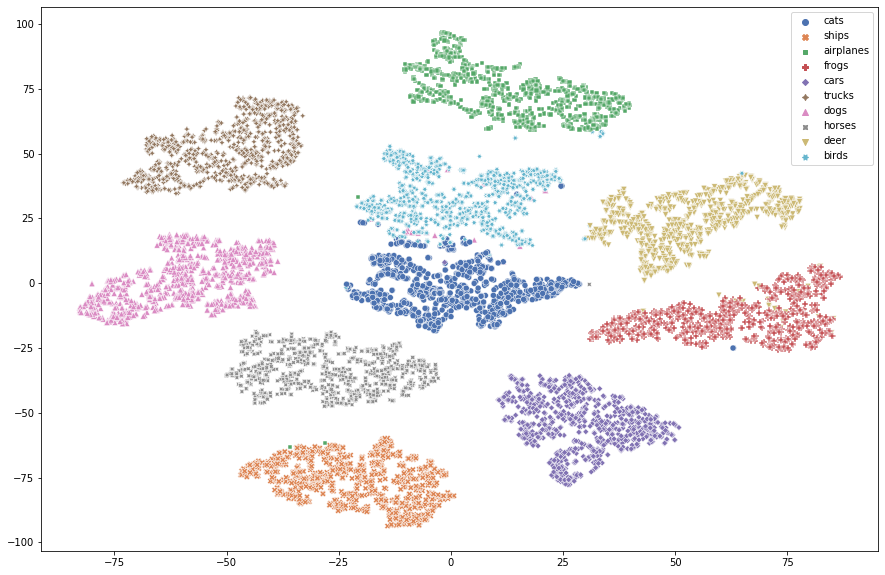

In [15]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_benchmarks/resExploss_CIFAR10_tsne.png')


# CIFAR-100 VGG

In [21]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = datasets.CIFAR100(root='/tf/data/benchmark_datasets/cifar100', train=True, download=False, 
                            transform=train_transforms)

test_set = datasets.CIFAR100(root='/tf/data/benchmark_datasets/cifar100', train=False, download=False, 
                            transform=test_transforms)

In [22]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)


### From scratch

In [23]:
# create model
device = torch.device('cuda')
lr = 0.001
model = sVGG_exp(features=vgg16_bn(pretrained=False).features[:34], in_features_classifier=512, n_classes=100)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

In [9]:
model_path = 'exploss_benchmarks/resExploss_CIFAR100_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=4.104518413543701 Batch_id=195 Accuracy=0.05: 100%|██████████| 196/196 [00:23<00:00,  8.20it/s]       

- Avg.loss: 4.2864 | Avg.acc: 0.0305



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 3.8975 | Avg. test_acc: 0.0492
* Update optimal model
Epoch:  2


Loss=3.723367214202881 Batch_id=195 Accuracy=0.025: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]      

- Avg.loss: 3.7455 | Avg.acc: 0.0681


- Avg. test_loss: 3.6083 | Avg. test_acc: 0.0840


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=4.483896732330322 Batch_id=195 Accuracy=0.0375: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]     

- Avg.loss: 3.5305 | Avg.acc: 0.0953


- Avg. test_loss: 3.4300 | Avg. test_acc: 0.1029


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=3.923853635787964 Batch_id=195 Accuracy=0.0875: 100%|██████████| 196/196 [00:23<00:00,  8.20it/s]     

- Avg.loss: 3.3350 | Avg.acc: 0.1222


- Avg. test_loss: 3.4350 | Avg. test_acc: 0.1070


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=3.422638416290283 Batch_id=195 Accuracy=0.1125: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]     

- Avg.loss: 3.1779 | Avg.acc: 0.1413


- Avg. test_loss: 3.2469 | Avg. test_acc: 0.1469


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=3.7041118144989014 Batch_id=195 Accuracy=0.0875: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]    

- Avg.loss: 3.0469 | Avg.acc: 0.1644


- Avg. test_loss: 2.8633 | Avg. test_acc: 0.1941


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=3.6034388542175293 Batch_id=195 Accuracy=0.1625: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]    

- Avg.loss: 2.9072 | Avg.acc: 0.1884



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.9377 | Avg. test_acc: 0.1825
Epoch:  8


Loss=3.4358623027801514 Batch_id=195 Accuracy=0.0875: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]    

- Avg.loss: 2.7929 | Avg.acc: 0.2141


- Avg. test_loss: 2.9639 | Avg. test_acc: 0.1951


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=3.100890874862671 Batch_id=195 Accuracy=0.1875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 2.6858 | Avg.acc: 0.2273


- Avg. test_loss: 2.7530 | Avg. test_acc: 0.2217


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=3.174597978591919 Batch_id=195 Accuracy=0.2125: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]     

- Avg.loss: 2.6058 | Avg.acc: 0.2460


- Avg. test_loss: 2.8582 | Avg. test_acc: 0.2254


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=3.2015178203582764 Batch_id=195 Accuracy=0.275: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 2.4598 | Avg.acc: 0.2828


- Avg. test_loss: 2.5364 | Avg. test_acc: 0.2839


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=3.6076111793518066 Batch_id=195 Accuracy=0.225: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]     

- Avg.loss: 2.3826 | Avg.acc: 0.3006


- Avg. test_loss: 2.3589 | Avg. test_acc: 0.2924


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=2.955526351928711 Batch_id=195 Accuracy=0.3375: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 2.2702 | Avg.acc: 0.3265


- Avg. test_loss: 2.1719 | Avg. test_acc: 0.3533


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=2.696936845779419 Batch_id=195 Accuracy=0.2875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 2.1890 | Avg.acc: 0.3523


- Avg. test_loss: 2.1630 | Avg. test_acc: 0.3645


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=2.9837663173675537 Batch_id=195 Accuracy=0.1875: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]    

- Avg.loss: 2.1166 | Avg.acc: 0.3701



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.2836 | Avg. test_acc: 0.3293
Epoch:  16


Loss=3.456768751144409 Batch_id=195 Accuracy=0.1625: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]     

- Avg.loss: 2.0126 | Avg.acc: 0.3951


- Avg. test_loss: 1.8568 | Avg. test_acc: 0.4215


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=2.7433278560638428 Batch_id=195 Accuracy=0.25: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]      

- Avg.loss: 1.9352 | Avg.acc: 0.4143



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.3213 | Avg. test_acc: 0.3696
Epoch:  18


Loss=2.7193009853363037 Batch_id=195 Accuracy=0.3375: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]    

- Avg.loss: 1.8659 | Avg.acc: 0.4370


- Avg. test_loss: 1.9359 | Avg. test_acc: 0.4364


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=3.4773621559143066 Batch_id=195 Accuracy=0.3: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]       

- Avg.loss: 1.7686 | Avg.acc: 0.4621


- Avg. test_loss: 1.6038 | Avg. test_acc: 0.5162


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=2.6415529251098633 Batch_id=195 Accuracy=0.3375: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]    

- Avg.loss: 1.7267 | Avg.acc: 0.4815



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.5987 | Avg. test_acc: 0.5096
Epoch:  21


Loss=2.769622564315796 Batch_id=195 Accuracy=0.3625: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 1.6512 | Avg.acc: 0.4974



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.7779 | Avg. test_acc: 0.4754
Epoch:  22


Loss=2.6629021167755127 Batch_id=195 Accuracy=0.3375: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]    

- Avg.loss: 1.5578 | Avg.acc: 0.5258



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.8875 | Avg. test_acc: 0.4708
Epoch:  23


Loss=2.554351806640625 Batch_id=195 Accuracy=0.425: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]      

- Avg.loss: 1.5311 | Avg.acc: 0.5376


- Avg. test_loss: 1.4281 | Avg. test_acc: 0.5612


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=2.7959370613098145 Batch_id=195 Accuracy=0.425: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]     

- Avg.loss: 1.4337 | Avg.acc: 0.5664


- Avg. test_loss: 1.4225 | Avg. test_acc: 0.5745


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=2.927402973175049 Batch_id=195 Accuracy=0.375: 100%|██████████| 196/196 [00:24<00:00,  8.05it/s]      

- Avg.loss: 1.3834 | Avg.acc: 0.5728



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.5052 | Avg. test_acc: 0.5557
Epoch:  26


Loss=2.311984062194824 Batch_id=195 Accuracy=0.425: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]      

- Avg.loss: 1.3194 | Avg.acc: 0.5941


- Avg. test_loss: 1.3067 | Avg. test_acc: 0.6023


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=2.5854668617248535 Batch_id=195 Accuracy=0.4875: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]    

- Avg.loss: 1.2734 | Avg.acc: 0.6108


- Avg. test_loss: 1.2665 | Avg. test_acc: 0.6080


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=1.868303656578064 Batch_id=195 Accuracy=0.525: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]      

- Avg.loss: 1.2426 | Avg.acc: 0.6209


- Avg. test_loss: 1.2227 | Avg. test_acc: 0.6192


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=1.740201711654663 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]     

- Avg.loss: 1.1699 | Avg.acc: 0.6426


- Avg. test_loss: 1.2080 | Avg. test_acc: 0.6302


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=2.3120954036712646 Batch_id=195 Accuracy=0.4125: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]    

- Avg.loss: 1.1279 | Avg.acc: 0.6537


- Avg. test_loss: 1.0960 | Avg. test_acc: 0.6614


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=2.2559094429016113 Batch_id=195 Accuracy=0.475: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]     

- Avg.loss: 1.1090 | Avg.acc: 0.6626



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2294 | Avg. test_acc: 0.6478
Epoch:  32


Loss=1.6166423559188843 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]      

- Avg.loss: 1.0619 | Avg.acc: 0.6816



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.4163 | Avg. test_acc: 0.6005
Epoch:  33


Loss=2.3424761295318604 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]    

- Avg.loss: 1.0229 | Avg.acc: 0.6878


- Avg. test_loss: 1.1131 | Avg. test_acc: 0.6775


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=1.7473554611206055 Batch_id=195 Accuracy=0.575: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 1.0010 | Avg.acc: 0.6987


- Avg. test_loss: 0.9295 | Avg. test_acc: 0.7182


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=2.2406232357025146 Batch_id=195 Accuracy=0.5: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]       

- Avg.loss: 0.9494 | Avg.acc: 0.7113



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.0040 | Avg. test_acc: 0.7069
Epoch:  36


Loss=1.9370428323745728 Batch_id=195 Accuracy=0.525: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]     

- Avg.loss: 0.9370 | Avg.acc: 0.7190



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1051 | Avg. test_acc: 0.6711
Epoch:  37


Loss=1.432475209236145 Batch_id=195 Accuracy=0.5: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]        

- Avg.loss: 0.9009 | Avg.acc: 0.7346



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.9664 | Avg. test_acc: 0.7020
Epoch:  38


Loss=1.8857243061065674 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]    

- Avg.loss: 0.8915 | Avg.acc: 0.7342


- Avg. test_loss: 0.8862 | Avg. test_acc: 0.7306


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=1.9900124073028564 Batch_id=195 Accuracy=0.5: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]       

- Avg.loss: 0.8489 | Avg.acc: 0.7479


- Avg. test_loss: 0.8704 | Avg. test_acc: 0.7392


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=1.9363033771514893 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]    

- Avg.loss: 0.8270 | Avg.acc: 0.7554



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.8864 | Avg. test_acc: 0.7289
Epoch:  41


Loss=1.2549936771392822 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]    

- Avg.loss: 0.8013 | Avg.acc: 0.7652


- Avg. test_loss: 0.8462 | Avg. test_acc: 0.7571


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=1.9013965129852295 Batch_id=195 Accuracy=0.6: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]       

- Avg.loss: 0.7704 | Avg.acc: 0.7731


- Avg. test_loss: 0.8205 | Avg. test_acc: 0.7593


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  43


Loss=2.3030385971069336 Batch_id=195 Accuracy=0.5375: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]    

- Avg.loss: 0.7478 | Avg.acc: 0.7814



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.9601 | Avg. test_acc: 0.7275
Epoch:  44


Loss=1.9386301040649414 Batch_id=195 Accuracy=0.6: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]       

- Avg.loss: 0.7263 | Avg.acc: 0.7868



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.9706 | Avg. test_acc: 0.7224
Epoch:  45


Loss=1.222919225692749 Batch_id=195 Accuracy=0.675: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]       

- Avg.loss: 0.7352 | Avg.acc: 0.7870



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.8678 | Avg. test_acc: 0.7454
Epoch:  46


Loss=1.6065393686294556 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]     

- Avg.loss: 0.7039 | Avg.acc: 0.7962


- Avg. test_loss: 0.7567 | Avg. test_acc: 0.7747


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  47


Loss=1.4378902912139893 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]    

- Avg.loss: 0.6828 | Avg.acc: 0.8025



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.8449 | Avg. test_acc: 0.7533
Epoch:  48


Loss=1.3327373266220093 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]    

- Avg.loss: 0.6590 | Avg.acc: 0.8104


- Avg. test_loss: 0.7723 | Avg. test_acc: 0.7749


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  49


Loss=1.5769884586334229 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]     

- Avg.loss: 0.6510 | Avg.acc: 0.8124


- Avg. test_loss: 0.7463 | Avg. test_acc: 0.7835


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  50


Loss=1.4795386791229248 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]      

- Avg.loss: 0.6419 | Avg.acc: 0.8169


- Avg. test_loss: 0.7544 | Avg. test_acc: 0.7753


In [10]:
for epoch in range(50, 100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  51


Loss=0.9145882725715637 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]     

- Avg.loss: 0.6268 | Avg.acc: 0.8222


- Avg. test_loss: 0.6821 | Avg. test_acc: 0.7980


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  52


Loss=1.1251823902130127 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]     

- Avg.loss: 0.6093 | Avg.acc: 0.8258



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.8391 | Avg. test_acc: 0.7495
Epoch:  53


Loss=1.2285603284835815 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]     

- Avg.loss: 0.5909 | Avg.acc: 0.8308


- Avg. test_loss: 0.6658 | Avg. test_acc: 0.8076


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  54


Loss=1.357975721359253 Batch_id=195 Accuracy=0.6375: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]      

- Avg.loss: 0.5849 | Avg.acc: 0.8366



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.9219 | Avg. test_acc: 0.7521
Epoch:  55


Loss=2.339427947998047 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]      

- Avg.loss: 0.5967 | Avg.acc: 0.8337



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7853 | Avg. test_acc: 0.7804
Epoch:  56


Loss=1.4251662492752075 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 0.5701 | Avg.acc: 0.8373



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7819 | Avg. test_acc: 0.7795
Epoch:  57


Loss=1.7757995128631592 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]     

- Avg.loss: 0.5532 | Avg.acc: 0.8436



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7504 | Avg. test_acc: 0.7921
Epoch:  58


Loss=2.0217204093933105 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]     

- Avg.loss: 0.5254 | Avg.acc: 0.8505


- Avg. test_loss: 0.6574 | Avg. test_acc: 0.8100


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  59


Loss=1.0271812677383423 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 0.5470 | Avg.acc: 0.8468



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6804 | Avg. test_acc: 0.8055
Epoch:  60


Loss=0.9796321988105774 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]     

- Avg.loss: 0.5192 | Avg.acc: 0.8536



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.8118 | Avg. test_acc: 0.7807
Epoch:  61


Loss=1.3285303115844727 Batch_id=195 Accuracy=0.6375: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]     

- Avg.loss: 0.5051 | Avg.acc: 0.8581


- Avg. test_loss: 0.6533 | Avg. test_acc: 0.8121


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  62


Loss=1.7375043630599976 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:24<00:00,  8.04it/s]        

- Avg.loss: 0.4894 | Avg.acc: 0.8627


- Avg. test_loss: 0.6380 | Avg. test_acc: 0.8196


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  63


Loss=2.1174235343933105 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]     

- Avg.loss: 0.5044 | Avg.acc: 0.8612


- Avg. test_loss: 0.6496 | Avg. test_acc: 0.8213


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  64


Loss=1.2791285514831543 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]        

- Avg.loss: 0.4684 | Avg.acc: 0.8679



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7589 | Avg. test_acc: 0.7817
Epoch:  65


Loss=2.035184383392334 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]      

- Avg.loss: 0.4776 | Avg.acc: 0.8683



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.0782 | Avg. test_acc: 0.7360
Epoch:  66


Loss=2.044832944869995 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:24<00:00,  8.17it/s]        

- Avg.loss: 0.4910 | Avg.acc: 0.8647


- Avg. test_loss: 0.6258 | Avg. test_acc: 0.8219


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  67


Loss=0.957484245300293 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]       

- Avg.loss: 0.4699 | Avg.acc: 0.8697



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7083 | Avg. test_acc: 0.8123
Epoch:  68


Loss=2.0344443321228027 Batch_id=195 Accuracy=0.6: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]        

- Avg.loss: 0.4662 | Avg.acc: 0.8720


- Avg. test_loss: 0.6037 | Avg. test_acc: 0.8228


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  69


Loss=0.8125268816947937 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]        

- Avg.loss: 0.4594 | Avg.acc: 0.8746



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6789 | Avg. test_acc: 0.8044
Epoch:  70


Loss=1.1039413213729858 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]       

- Avg.loss: 0.4514 | Avg.acc: 0.8790



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6899 | Avg. test_acc: 0.8185
Epoch:  71


Loss=1.0127484798431396 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]      

- Avg.loss: 0.4515 | Avg.acc: 0.8759



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6467 | Avg. test_acc: 0.8215
Epoch:  72


Loss=2.3385839462280273 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]     

- Avg.loss: 0.4449 | Avg.acc: 0.8812


- Avg. test_loss: 0.6050 | Avg. test_acc: 0.8340


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  73


Loss=1.3677490949630737 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]     

- Avg.loss: 0.4363 | Avg.acc: 0.8799



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6553 | Avg. test_acc: 0.8242
Epoch:  74


Loss=1.779842734336853 Batch_id=195 Accuracy=0.6: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]         

- Avg.loss: 0.4317 | Avg.acc: 0.8819



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6490 | Avg. test_acc: 0.8216
Epoch:  75


Loss=1.0805974006652832 Batch_id=195 Accuracy=0.725: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]      

- Avg.loss: 0.4360 | Avg.acc: 0.8793



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7547 | Avg. test_acc: 0.8028
Epoch:  76


Loss=1.6995418071746826 Batch_id=195 Accuracy=0.675: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]      

- Avg.loss: 0.4185 | Avg.acc: 0.8866


- Avg. test_loss: 0.5362 | Avg. test_acc: 0.8478


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  77


Loss=1.2889686822891235 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 0.4104 | Avg.acc: 0.8856



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5896 | Avg. test_acc: 0.8326
Epoch:  78


Loss=0.9434741139411926 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:23<00:00,  8.17it/s]       

- Avg.loss: 0.4230 | Avg.acc: 0.8865



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5674 | Avg. test_acc: 0.8454
Epoch:  79


Loss=1.866081953048706 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]      

- Avg.loss: 0.4074 | Avg.acc: 0.8881



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5609 | Avg. test_acc: 0.8352
Epoch:  80


Loss=1.9146983623504639 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]       

- Avg.loss: 0.4234 | Avg.acc: 0.8872



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5875 | Avg. test_acc: 0.8324
Epoch:  81


Loss=1.7300420999526978 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]      

- Avg.loss: 0.4182 | Avg.acc: 0.8873



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7054 | Avg. test_acc: 0.8037
Epoch:  82


Loss=1.5730587244033813 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]       

- Avg.loss: 0.4112 | Avg.acc: 0.8896



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6288 | Avg. test_acc: 0.8234
Epoch    82: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  83


Loss=0.9050401449203491 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]        

- Avg.loss: 0.2972 | Avg.acc: 0.9197


- Avg. test_loss: 0.4041 | Avg. test_acc: 0.8868


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  84


Loss=0.6022018194198608 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]      

- Avg.loss: 0.2560 | Avg.acc: 0.9308



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3973 | Avg. test_acc: 0.8854
Epoch:  85


Loss=0.7285569310188293 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]        

- Avg.loss: 0.2428 | Avg.acc: 0.9342


- Avg. test_loss: 0.3861 | Avg. test_acc: 0.8938


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  86


Loss=0.822455883026123 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]      

- Avg.loss: 0.2265 | Avg.acc: 0.9382



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3809 | Avg. test_acc: 0.8930
Epoch:  87


Loss=0.6925889849662781 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]      

- Avg.loss: 0.2272 | Avg.acc: 0.9399



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3909 | Avg. test_acc: 0.8859
Epoch:  88


Loss=0.5685882568359375 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]      

- Avg.loss: 0.2216 | Avg.acc: 0.9414



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3787 | Avg. test_acc: 0.8886
Epoch:  89


Loss=0.40827593207359314 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 0.2078 | Avg.acc: 0.9441



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3758 | Avg. test_acc: 0.8922
Epoch:  90


Loss=1.1926296949386597 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]     

- Avg.loss: 0.2081 | Avg.acc: 0.9424


- Avg. test_loss: 0.3775 | Avg. test_acc: 0.8941


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  91


Loss=0.7095092535018921 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 0.2104 | Avg.acc: 0.9429



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3821 | Avg. test_acc: 0.8915
Epoch:  92


Loss=0.4207170903682709 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]      

- Avg.loss: 0.2001 | Avg.acc: 0.9451


- Avg. test_loss: 0.3734 | Avg. test_acc: 0.8948


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  93


Loss=0.625598669052124 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]      

- Avg.loss: 0.2042 | Avg.acc: 0.9447


- Avg. test_loss: 0.3722 | Avg. test_acc: 0.8972


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  94


Loss=0.9452352523803711 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]        

- Avg.loss: 0.1957 | Avg.acc: 0.9470



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3623 | Avg. test_acc: 0.8955
Epoch:  95


Loss=0.6539985537528992 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 0.1870 | Avg.acc: 0.9498



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3653 | Avg. test_acc: 0.8957
Epoch:  96


Loss=0.42268213629722595 Batch_id=195 Accuracy=0.9125: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]    

- Avg.loss: 0.1915 | Avg.acc: 0.9483



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3702 | Avg. test_acc: 0.8933
Epoch:  97


Loss=0.6965967416763306 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]     

- Avg.loss: 0.1868 | Avg.acc: 0.9485


- Avg. test_loss: 0.3682 | Avg. test_acc: 0.8981


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  98


Loss=0.689025342464447 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]       

- Avg.loss: 0.1858 | Avg.acc: 0.9506



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3641 | Avg. test_acc: 0.8965
Epoch:  99


Loss=0.9126373529434204 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]        

- Avg.loss: 0.1785 | Avg.acc: 0.9521



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3673 | Avg. test_acc: 0.8949
Epoch:  100


Loss=1.087766408920288 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]      

- Avg.loss: 0.1839 | Avg.acc: 0.9509


- Avg. test_loss: 0.3707 | Avg. test_acc: 0.8970


In [11]:
for epoch in range(100, 150):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  101


Loss=0.4522537291049957 Batch_id=195 Accuracy=0.925: 100%|██████████| 196/196 [00:23<00:00,  8.22it/s]      

- Avg.loss: 0.1771 | Avg.acc: 0.9520



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3714 | Avg. test_acc: 0.8958
Epoch:  102


Loss=0.8915384411811829 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]       

- Avg.loss: 0.1759 | Avg.acc: 0.9530



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3772 | Avg. test_acc: 0.8957
Epoch:  103


Loss=0.8299106359481812 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 0.1712 | Avg.acc: 0.9551



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3616 | Avg. test_acc: 0.8975
Epoch   103: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  104


Loss=0.7636748552322388 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]         

- Avg.loss: 0.1686 | Avg.acc: 0.9542


- Avg. test_loss: 0.3607 | Avg. test_acc: 0.8998


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  105


Loss=1.017474889755249 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]         

- Avg.loss: 0.1587 | Avg.acc: 0.9579


- Avg. test_loss: 0.3585 | Avg. test_acc: 0.9000


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  106


Loss=0.4661251902580261 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 0.1685 | Avg.acc: 0.9554


- Avg. test_loss: 0.3560 | Avg. test_acc: 0.9012


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  107


Loss=0.7537914514541626 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]       

- Avg.loss: 0.1612 | Avg.acc: 0.9558


- Avg. test_loss: 0.3523 | Avg. test_acc: 0.9023


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  108


Loss=0.530011773109436 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]       

- Avg.loss: 0.1704 | Avg.acc: 0.9546


- Avg. test_loss: 0.3542 | Avg. test_acc: 0.9026


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  109


Loss=1.0676000118255615 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 0.1654 | Avg.acc: 0.9559



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3564 | Avg. test_acc: 0.9015
Epoch:  110


Loss=0.8309313058853149 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]     

- Avg.loss: 0.1692 | Avg.acc: 0.9543



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3582 | Avg. test_acc: 0.9016
Epoch:  111


Loss=0.7338250279426575 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]       

- Avg.loss: 0.1593 | Avg.acc: 0.9582


- Avg. test_loss: 0.3539 | Avg. test_acc: 0.9031


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  112


Loss=0.5859676599502563 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:23<00:00,  8.17it/s]      

- Avg.loss: 0.1600 | Avg.acc: 0.9569



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3564 | Avg. test_acc: 0.9012
Epoch:  113


Loss=1.285653829574585 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]       

- Avg.loss: 0.1581 | Avg.acc: 0.9577



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3527 | Avg. test_acc: 0.9024
Epoch:  114


Loss=0.5984222292900085 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]     

- Avg.loss: 0.1634 | Avg.acc: 0.9559



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3546 | Avg. test_acc: 0.9011
Epoch:  115


Loss=0.24642476439476013 Batch_id=195 Accuracy=0.9125: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]    

- Avg.loss: 0.1579 | Avg.acc: 0.9578



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3523 | Avg. test_acc: 0.9028
Epoch:  116


Loss=0.7470595836639404 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:24<00:00,  8.08it/s]     

- Avg.loss: 0.1657 | Avg.acc: 0.9562



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3531 | Avg. test_acc: 0.9023
Epoch:  117


Loss=0.8252681493759155 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]      

- Avg.loss: 0.1589 | Avg.acc: 0.9574



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3605 | Avg. test_acc: 0.8986
Epoch   117: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  118


Loss=0.4701102674007416 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]        

- Avg.loss: 0.1533 | Avg.acc: 0.9584



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3550 | Avg. test_acc: 0.8981
Epoch:  119


Loss=0.4412164092063904 Batch_id=195 Accuracy=0.9125: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]     

- Avg.loss: 0.1607 | Avg.acc: 0.9567



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3543 | Avg. test_acc: 0.9004
Epoch:  120


Loss=0.8868519067764282 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]      

- Avg.loss: 0.1624 | Avg.acc: 0.9567



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3556 | Avg. test_acc: 0.8996
Epoch:  121


Loss=0.6945215463638306 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 0.1542 | Avg.acc: 0.9588



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3499 | Avg. test_acc: 0.9017
Epoch:  122


Loss=0.49335211515426636 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]    

- Avg.loss: 0.1566 | Avg.acc: 0.9573



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3522 | Avg. test_acc: 0.9019
Epoch:  123


Loss=1.1857426166534424 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]     

- Avg.loss: 0.1603 | Avg.acc: 0.9584



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3512 | Avg. test_acc: 0.9012
Epoch   123: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  124


Loss=0.6202770471572876 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 0.1618 | Avg.acc: 0.9569



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3584 | Avg. test_acc: 0.8987
Epoch:  125


Loss=0.5755219459533691 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]        

- Avg.loss: 0.1593 | Avg.acc: 0.9564



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3505 | Avg. test_acc: 0.9022
Epoch:  126


Loss=0.7490428686141968 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.05it/s]      

- Avg.loss: 0.1629 | Avg.acc: 0.9574



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3544 | Avg. test_acc: 0.8999
Epoch:  127


Loss=0.4617246687412262 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]     

- Avg.loss: 0.1560 | Avg.acc: 0.9593



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3529 | Avg. test_acc: 0.9026
Epoch:  128


Loss=0.6725738048553467 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]       

- Avg.loss: 0.1646 | Avg.acc: 0.9564



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3532 | Avg. test_acc: 0.9006
Epoch:  129


Loss=0.6275789737701416 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]      

- Avg.loss: 0.1596 | Avg.acc: 0.9572



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3637 | Avg. test_acc: 0.8965
Epoch   129: reducing learning rate of group 0 to 1.0000e-08.
Epoch:  130


Loss=0.19195595383644104 Batch_id=195 Accuracy=0.95: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]      

- Avg.loss: 0.1561 | Avg.acc: 0.9583



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3555 | Avg. test_acc: 0.9001
Epoch:  131


Loss=0.7095436453819275 Batch_id=195 Accuracy=0.9125: 100%|██████████| 196/196 [00:24<00:00,  8.12it/s]     

- Avg.loss: 0.1633 | Avg.acc: 0.9554



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3576 | Avg. test_acc: 0.8989
Epoch:  132


Loss=0.6423152685165405 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]        

- Avg.loss: 0.1614 | Avg.acc: 0.9571



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3529 | Avg. test_acc: 0.9013
Epoch:  133


Loss=0.75886470079422 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]       

- Avg.loss: 0.1544 | Avg.acc: 0.9585



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3512 | Avg. test_acc: 0.9027
Epoch:  134


Loss=0.8473374247550964 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]     

- Avg.loss: 0.1550 | Avg.acc: 0.9585



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3523 | Avg. test_acc: 0.9010
Epoch:  135


Loss=0.5742319822311401 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]       

- Avg.loss: 0.1547 | Avg.acc: 0.9584



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3563 | Avg. test_acc: 0.9016
Epoch:  136


Loss=0.4079808294773102 Batch_id=195 Accuracy=0.9375: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]     

- Avg.loss: 0.1588 | Avg.acc: 0.9577



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3555 | Avg. test_acc: 0.8977
Epoch:  137


Loss=1.3917210102081299 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]     

- Avg.loss: 0.1554 | Avg.acc: 0.9584



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3588 | Avg. test_acc: 0.9000
Epoch:  138


Loss=0.8877474069595337 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]        

- Avg.loss: 0.1631 | Avg.acc: 0.9560



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3528 | Avg. test_acc: 0.9006
Epoch:  139


Loss=0.341075599193573 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]         

- Avg.loss: 0.1566 | Avg.acc: 0.9588



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3529 | Avg. test_acc: 0.9003
Epoch:  140


Loss=0.2962723672389984 Batch_id=195 Accuracy=0.9375: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]     

- Avg.loss: 0.1553 | Avg.acc: 0.9576



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3542 | Avg. test_acc: 0.9015
Epoch:  141


Loss=0.5308027863502502 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:24<00:00,  8.15it/s]     

- Avg.loss: 0.1582 | Avg.acc: 0.9573



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3505 | Avg. test_acc: 0.9015
Epoch:  142


Loss=0.8576359748840332 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]      

- Avg.loss: 0.1526 | Avg.acc: 0.9596



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3558 | Avg. test_acc: 0.9014
Epoch:  143


Loss=0.8411439657211304 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]       

- Avg.loss: 0.1563 | Avg.acc: 0.9576



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3517 | Avg. test_acc: 0.8998
Epoch:  144


Loss=0.5484150648117065 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]     

- Avg.loss: 0.1561 | Avg.acc: 0.9588



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3561 | Avg. test_acc: 0.9001
Epoch:  145


Loss=0.6382578015327454 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]       

- Avg.loss: 0.1551 | Avg.acc: 0.9585



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3528 | Avg. test_acc: 0.9021
Epoch:  146


Loss=0.9005097150802612 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]       

- Avg.loss: 0.1604 | Avg.acc: 0.9571



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3561 | Avg. test_acc: 0.9009
Epoch:  147


Loss=0.6981440186500549 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]       

- Avg.loss: 0.1602 | Avg.acc: 0.9571



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3505 | Avg. test_acc: 0.9019
Epoch:  148


Loss=0.9231494069099426 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]     

- Avg.loss: 0.1533 | Avg.acc: 0.9592



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3528 | Avg. test_acc: 0.9018
Epoch:  149


Loss=0.9162570238113403 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]      

- Avg.loss: 0.1556 | Avg.acc: 0.9590



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3578 | Avg. test_acc: 0.8993
Epoch:  150


Loss=0.7642090916633606 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]      

- Avg.loss: 0.1560 | Avg.acc: 0.9585


- Avg. test_loss: 0.3541 | Avg. test_acc: 0.9008


In [12]:
pickle.dump(hist, open('exploss_benchmarks/resExploss_CIFAR100_hist.hdf5', 'wb'))

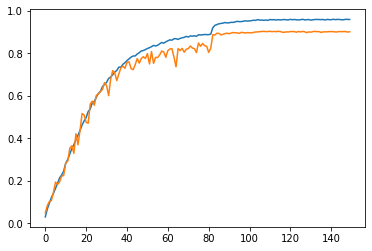

(0.9031, 0.35392976341247556)

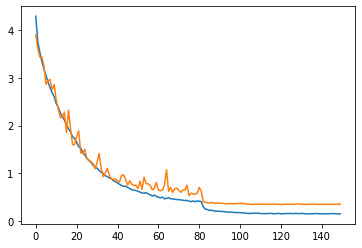

In [13]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])

best_acc, curloss

In [8]:
model = torch.load('exploss_benchmarks/resExploss_CIFAR100_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


- Avg. val_loss: 0.3539 | Avg. val_acc: 0.9031


In [9]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([10000, 512])

In [10]:
label_dict = dict(zip(np.arange(100), [str(k) for k in np.arange(100)]))
label_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '10',
 11: '11',
 12: '12',
 13: '13',
 14: '14',
 15: '15',
 16: '16',
 17: '17',
 18: '18',
 19: '19',
 20: '20',
 21: '21',
 22: '22',
 23: '23',
 24: '24',
 25: '25',
 26: '26',
 27: '27',
 28: '28',
 29: '29',
 30: '30',
 31: '31',
 32: '32',
 33: '33',
 34: '34',
 35: '35',
 36: '36',
 37: '37',
 38: '38',
 39: '39',
 40: '40',
 41: '41',
 42: '42',
 43: '43',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '53',
 54: '54',
 55: '55',
 56: '56',
 57: '57',
 58: '58',
 59: '59',
 60: '60',
 61: '61',
 62: '62',
 63: '63',
 64: '64',
 65: '65',
 66: '66',
 67: '67',
 68: '68',
 69: '69',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '80',
 81: '81',
 82: '82',
 83: '83',
 84: '84',
 85: '85',
 86: '86',
 87: '87',
 88: '88',
 89: '89',
 90: '90',
 91: '91',
 92: '92

(<Figure size 1080x720 with 1 Axes>, array([[-55.89979  ,  34.318806 ],
        [-22.897715 ,  65.70303  ],
        [  8.581028 , -16.120182 ],
        ...,
        [-25.95059  ,  33.730755 ],
        [ 18.23285  , -81.64046  ],
        [  4.4511623,  68.1096   ]], dtype=float32))

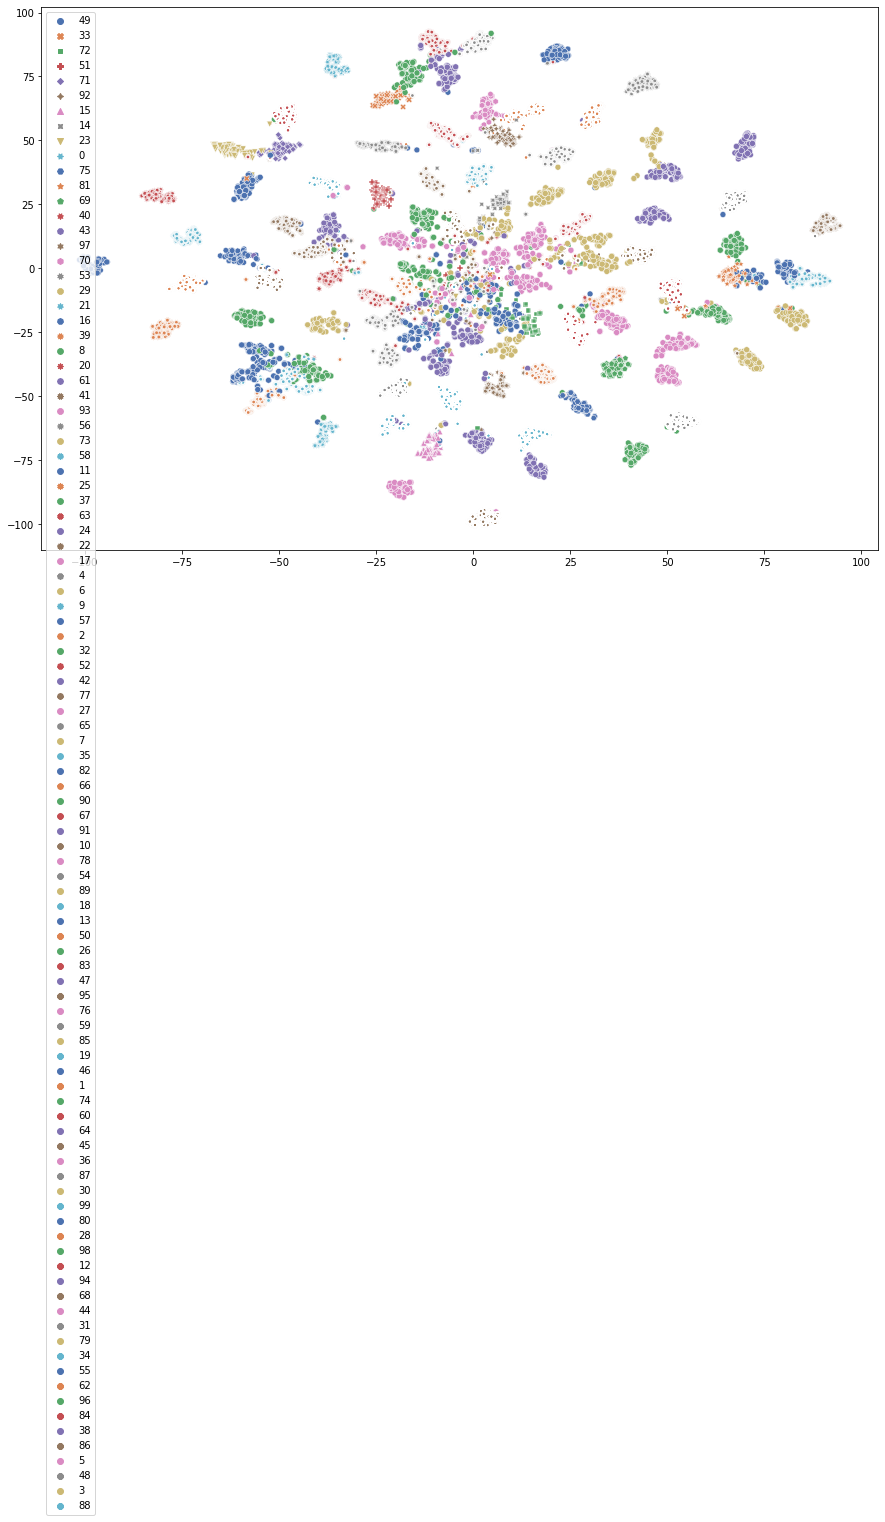

In [11]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_benchmarks/resExploss_CIFAR100_tsne.png')


### Pretrained

In [28]:
# create model
device = torch.device('cuda')
lr = 0.001
model = sVGG_exp(features=vgg16_bn(pretrained=True).features[:34], in_features_classifier=512, n_classes=100, residual=False)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

In [29]:
model_path = 'exploss_benchmarks/pretrainedVGG_Exploss_CIFAR100_model.pt'
epochs = 100
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  1


Loss=2.9642536640167236 Batch_id=195 Accuracy=0.1625: 100%|██████████| 196/196 [00:22<00:00,  8.61it/s]    

- Avg.loss: 3.6872 | Avg.acc: 0.0888



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 4.0651 | Avg. test_acc: 0.0839
* Update optimal model
Epoch:  2


Loss=3.3117072582244873 Batch_id=195 Accuracy=0.2: 100%|██████████| 196/196 [00:22<00:00,  8.55it/s]       

- Avg.loss: 2.5299 | Avg.acc: 0.2537


- Avg. test_loss: 2.5526 | Avg. test_acc: 0.2765


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=2.493988513946533 Batch_id=195 Accuracy=0.3125: 100%|██████████| 196/196 [00:22<00:00,  8.55it/s]     

- Avg.loss: 1.9683 | Avg.acc: 0.3879


- Avg. test_loss: 1.9537 | Avg. test_acc: 0.4325


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=2.3672561645507812 Batch_id=195 Accuracy=0.3875: 100%|██████████| 196/196 [00:23<00:00,  8.52it/s]    

- Avg.loss: 1.6214 | Avg.acc: 0.4947


- Avg. test_loss: 1.9747 | Avg. test_acc: 0.4710


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.9700543880462646 Batch_id=195 Accuracy=0.425: 100%|██████████| 196/196 [00:23<00:00,  8.50it/s]     

- Avg.loss: 1.3906 | Avg.acc: 0.5620


- Avg. test_loss: 1.2703 | Avg. test_acc: 0.6042


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.92009699344635 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:23<00:00,  8.52it/s]       

- Avg.loss: 1.2289 | Avg.acc: 0.6169


- Avg. test_loss: 1.2229 | Avg. test_acc: 0.6285


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.7158597707748413 Batch_id=195 Accuracy=0.4875: 100%|██████████| 196/196 [00:23<00:00,  8.47it/s]    

- Avg.loss: 1.0894 | Avg.acc: 0.6640


- Avg. test_loss: 1.1108 | Avg. test_acc: 0.6624


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.7155637741088867 Batch_id=195 Accuracy=0.525: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]     

- Avg.loss: 0.9918 | Avg.acc: 0.6945



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1294 | Avg. test_acc: 0.6618
Epoch:  9


Loss=1.605699896812439 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:23<00:00,  8.43it/s]     

- Avg.loss: 0.9294 | Avg.acc: 0.7167


- Avg. test_loss: 0.9286 | Avg. test_acc: 0.7200


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.5669058561325073 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:22<00:00,  8.60it/s]     

- Avg.loss: 0.8397 | Avg.acc: 0.7468


- Avg. test_loss: 0.8643 | Avg. test_acc: 0.7295


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.8426309823989868 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]    

- Avg.loss: 0.7912 | Avg.acc: 0.7662


- Avg. test_loss: 0.8811 | Avg. test_acc: 0.7316


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.5822449922561646 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:23<00:00,  8.43it/s]     

- Avg.loss: 0.7300 | Avg.acc: 0.7842


- Avg. test_loss: 0.8288 | Avg. test_acc: 0.7558


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.7839126586914062 Batch_id=195 Accuracy=0.525: 100%|██████████| 196/196 [00:23<00:00,  8.46it/s]     

- Avg.loss: 0.7052 | Avg.acc: 0.7916



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.9395 | Avg. test_acc: 0.7269
Epoch:  14


Loss=1.2366504669189453 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:23<00:00,  8.50it/s]      

- Avg.loss: 0.6958 | Avg.acc: 0.7994


- Avg. test_loss: 0.7581 | Avg. test_acc: 0.7782


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=1.8815500736236572 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:22<00:00,  8.52it/s]     

- Avg.loss: 0.6449 | Avg.acc: 0.8141



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.9517 | Avg. test_acc: 0.7395
Epoch:  16


Loss=1.0729597806930542 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:23<00:00,  8.37it/s]       

- Avg.loss: 0.6173 | Avg.acc: 0.8208



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.9031 | Avg. test_acc: 0.7425
Epoch:  17


Loss=1.0311906337738037 Batch_id=195 Accuracy=0.725: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]      

- Avg.loss: 0.6166 | Avg.acc: 0.8208



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.0341 | Avg. test_acc: 0.7270
Epoch:  18


Loss=1.639797568321228 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:23<00:00,  8.47it/s]      

- Avg.loss: 0.5724 | Avg.acc: 0.8347


- Avg. test_loss: 0.8159 | Avg. test_acc: 0.7854


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.4272112846374512 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:23<00:00,  8.49it/s]     

- Avg.loss: 0.5607 | Avg.acc: 0.8373


- Avg. test_loss: 0.7169 | Avg. test_acc: 0.7926


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=1.5320285558700562 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:23<00:00,  8.42it/s]     

- Avg.loss: 0.5478 | Avg.acc: 0.8442


- Avg. test_loss: 0.6844 | Avg. test_acc: 0.8039


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=1.6884353160858154 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]       

- Avg.loss: 0.5202 | Avg.acc: 0.8510



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7393 | Avg. test_acc: 0.7934
Epoch:  22


Loss=1.3833842277526855 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]     

- Avg.loss: 0.5019 | Avg.acc: 0.8603



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6687 | Avg. test_acc: 0.8031
Epoch:  23


Loss=1.3999745845794678 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:23<00:00,  8.45it/s]     

- Avg.loss: 0.5221 | Avg.acc: 0.8530


- Avg. test_loss: 0.6974 | Avg. test_acc: 0.8041


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=1.1640983819961548 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:23<00:00,  8.47it/s]     

- Avg.loss: 0.4706 | Avg.acc: 0.8690


- Avg. test_loss: 0.6481 | Avg. test_acc: 0.8130


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=1.7042996883392334 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:23<00:00,  8.52it/s]       

- Avg.loss: 0.4695 | Avg.acc: 0.8703


- Avg. test_loss: 0.6316 | Avg. test_acc: 0.8229


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=1.4359732866287231 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:23<00:00,  8.40it/s]     

- Avg.loss: 0.4710 | Avg.acc: 0.8712



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6979 | Avg. test_acc: 0.8080
Epoch:  27


Loss=0.994601845741272 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:23<00:00,  8.45it/s]      

- Avg.loss: 0.4594 | Avg.acc: 0.8722



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6583 | Avg. test_acc: 0.8146
Epoch:  28


Loss=1.6212364435195923 Batch_id=195 Accuracy=0.725: 100%|██████████| 196/196 [00:23<00:00,  8.52it/s]      

- Avg.loss: 0.4601 | Avg.acc: 0.8738



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6559 | Avg. test_acc: 0.8171
Epoch:  29


Loss=1.377723217010498 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:23<00:00,  8.37it/s]      

- Avg.loss: 0.4259 | Avg.acc: 0.8827


- Avg. test_loss: 0.5588 | Avg. test_acc: 0.8404


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=1.5615589618682861 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]     

- Avg.loss: 0.4375 | Avg.acc: 0.8798



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6716 | Avg. test_acc: 0.8184
Epoch:  31


Loss=1.1341420412063599 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:23<00:00,  8.43it/s]     

- Avg.loss: 0.4185 | Avg.acc: 0.8872



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.8098 | Avg. test_acc: 0.7877
Epoch:  32


Loss=1.7273457050323486 Batch_id=195 Accuracy=0.675: 100%|██████████| 196/196 [00:23<00:00,  8.49it/s]      

- Avg.loss: 0.4034 | Avg.acc: 0.8890



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7858 | Avg. test_acc: 0.7926
Epoch:  33


Loss=1.852232575416565 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]      

- Avg.loss: 0.4155 | Avg.acc: 0.8872



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6445 | Avg. test_acc: 0.8193
Epoch:  34


Loss=0.979579746723175 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:22<00:00,  8.53it/s]       

- Avg.loss: 0.4316 | Avg.acc: 0.8847



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6533 | Avg. test_acc: 0.8254
Epoch:  35


Loss=1.1648590564727783 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:22<00:00,  8.52it/s]     

- Avg.loss: 0.3964 | Avg.acc: 0.8937


- Avg. test_loss: 0.5216 | Avg. test_acc: 0.8528


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  36


Loss=0.9307339787483215 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:23<00:00,  8.47it/s]     

- Avg.loss: 0.3671 | Avg.acc: 0.8993



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6959 | Avg. test_acc: 0.8263
Epoch:  37


Loss=0.9825875163078308 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:23<00:00,  8.46it/s]      

- Avg.loss: 0.3679 | Avg.acc: 0.9001


- Avg. test_loss: 0.5298 | Avg. test_acc: 0.8531


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=0.8142060041427612 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]        

- Avg.loss: 0.3814 | Avg.acc: 0.8969



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6019 | Avg. test_acc: 0.8311
Epoch:  39


Loss=1.4696080684661865 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:23<00:00,  8.49it/s]     

- Avg.loss: 0.3690 | Avg.acc: 0.9012



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6229 | Avg. test_acc: 0.8347
Epoch:  40


Loss=0.8103184700012207 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]     

- Avg.loss: 0.3749 | Avg.acc: 0.8996



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5571 | Avg. test_acc: 0.8425
Epoch:  41


Loss=0.9234593510627747 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]     

- Avg.loss: 0.3666 | Avg.acc: 0.9018



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5626 | Avg. test_acc: 0.8487
Epoch:  42


Loss=1.17146635055542 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:23<00:00,  8.49it/s]          

- Avg.loss: 0.3476 | Avg.acc: 0.9056



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6948 | Avg. test_acc: 0.8233
Epoch:  43


Loss=1.7584317922592163 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:23<00:00,  8.42it/s]       

- Avg.loss: 0.3709 | Avg.acc: 0.9014



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6983 | Avg. test_acc: 0.8263
Epoch    43: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  44


Loss=1.4097422361373901 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:23<00:00,  8.43it/s]        

- Avg.loss: 0.2702 | Avg.acc: 0.9290


- Avg. test_loss: 0.3706 | Avg. test_acc: 0.8935


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=1.4569532871246338 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]       

- Avg.loss: 0.2173 | Avg.acc: 0.9429


- Avg. test_loss: 0.3536 | Avg. test_acc: 0.8982


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  46


Loss=1.1697742938995361 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:23<00:00,  8.47it/s]      

- Avg.loss: 0.1979 | Avg.acc: 0.9470



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3539 | Avg. test_acc: 0.8968
Epoch:  47


Loss=0.9313365817070007 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]     

- Avg.loss: 0.1954 | Avg.acc: 0.9476


- Avg. test_loss: 0.3427 | Avg. test_acc: 0.9009


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  48


Loss=0.818069338798523 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]      

- Avg.loss: 0.1801 | Avg.acc: 0.9524



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3420 | Avg. test_acc: 0.9002
Epoch:  49


Loss=0.837628185749054 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]      

- Avg.loss: 0.1733 | Avg.acc: 0.9536


- Avg. test_loss: 0.3374 | Avg. test_acc: 0.9031


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  50


Loss=0.8946644067764282 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]     

- Avg.loss: 0.1723 | Avg.acc: 0.9539


- Avg. test_loss: 0.3423 | Avg. test_acc: 0.9042


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  51


Loss=0.651272177696228 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:23<00:00,  8.42it/s]         

- Avg.loss: 0.1637 | Avg.acc: 0.9563



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3376 | Avg. test_acc: 0.9020
Epoch:  52


Loss=0.8755639791488647 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:23<00:00,  8.42it/s]     

- Avg.loss: 0.1628 | Avg.acc: 0.9567


- Avg. test_loss: 0.3358 | Avg. test_acc: 0.9071


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  53


Loss=0.5555146336555481 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]     

- Avg.loss: 0.1540 | Avg.acc: 0.9590



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3316 | Avg. test_acc: 0.9046
Epoch:  54


Loss=0.7977577447891235 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:23<00:00,  8.46it/s]      

- Avg.loss: 0.1567 | Avg.acc: 0.9579



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3263 | Avg. test_acc: 0.9058
Epoch:  55


Loss=0.9411624073982239 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]     

- Avg.loss: 0.1577 | Avg.acc: 0.9587


- Avg. test_loss: 0.3319 | Avg. test_acc: 0.9099


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  56


Loss=1.225529432296753 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:23<00:00,  8.46it/s]       

- Avg.loss: 0.1535 | Avg.acc: 0.9591



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3266 | Avg. test_acc: 0.9072
Epoch:  57


Loss=0.42704111337661743 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:23<00:00,  8.40it/s]       

- Avg.loss: 0.1466 | Avg.acc: 0.9606



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3232 | Avg. test_acc: 0.9092
Epoch:  58


Loss=0.8688849210739136 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]     

- Avg.loss: 0.1436 | Avg.acc: 0.9618


- Avg. test_loss: 0.3170 | Avg. test_acc: 0.9110


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  59


Loss=0.35117533802986145 Batch_id=195 Accuracy=0.95: 100%|██████████| 196/196 [00:22<00:00,  8.53it/s]      

- Avg.loss: 0.1427 | Avg.acc: 0.9624



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3308 | Avg. test_acc: 0.9081
Epoch:  60


Loss=0.7079974412918091 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]     

- Avg.loss: 0.1437 | Avg.acc: 0.9615


- Avg. test_loss: 0.3206 | Avg. test_acc: 0.9124


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  61


Loss=0.5617328882217407 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]      

- Avg.loss: 0.1354 | Avg.acc: 0.9650



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3308 | Avg. test_acc: 0.9106
Epoch:  62


Loss=0.5561515688896179 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:23<00:00,  8.47it/s]       

- Avg.loss: 0.1302 | Avg.acc: 0.9652



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3458 | Avg. test_acc: 0.9036
Epoch:  63


Loss=0.8276389837265015 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:23<00:00,  8.52it/s]      

- Avg.loss: 0.1305 | Avg.acc: 0.9652



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3231 | Avg. test_acc: 0.9090
Epoch:  64


Loss=0.3748624324798584 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:22<00:00,  8.55it/s]      

- Avg.loss: 0.1258 | Avg.acc: 0.9655



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3296 | Avg. test_acc: 0.9069
Epoch:  65


Loss=0.4294448494911194 Batch_id=195 Accuracy=0.9125: 100%|██████████| 196/196 [00:23<00:00,  8.42it/s]      

- Avg.loss: 0.1264 | Avg.acc: 0.9661



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3262 | Avg. test_acc: 0.9095
Epoch:  66


Loss=1.4624313116073608 Batch_id=195 Accuracy=0.725: 100%|██████████| 196/196 [00:23<00:00,  8.46it/s]       

- Avg.loss: 0.1270 | Avg.acc: 0.9669



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3316 | Avg. test_acc: 0.9088
Epoch    66: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  67


Loss=0.7396973371505737 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]      

- Avg.loss: 0.1220 | Avg.acc: 0.9677



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3207 | Avg. test_acc: 0.9118
Epoch:  68


Loss=0.6357244253158569 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:22<00:00,  8.52it/s]         

- Avg.loss: 0.1222 | Avg.acc: 0.9670



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3244 | Avg. test_acc: 0.9115
Epoch:  69


Loss=0.9191383123397827 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]      

- Avg.loss: 0.1218 | Avg.acc: 0.9680



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3174 | Avg. test_acc: 0.9114
Epoch:  70


Loss=0.37202098965644836 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]        

- Avg.loss: 0.1193 | Avg.acc: 0.9683



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3210 | Avg. test_acc: 0.9105
Epoch:  71


Loss=0.7591385245323181 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:23<00:00,  8.45it/s]       

- Avg.loss: 0.1177 | Avg.acc: 0.9682



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3206 | Avg. test_acc: 0.9095
Epoch:  72


Loss=0.5537407398223877 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:23<00:00,  8.52it/s]      

- Avg.loss: 0.1177 | Avg.acc: 0.9690


- Avg. test_loss: 0.3153 | Avg. test_acc: 0.9130


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  73


Loss=0.5602405667304993 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]       

- Avg.loss: 0.1199 | Avg.acc: 0.9684



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3191 | Avg. test_acc: 0.9127
Epoch:  74


Loss=1.154024362564087 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:23<00:00,  8.50it/s]       

- Avg.loss: 0.1191 | Avg.acc: 0.9685



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3169 | Avg. test_acc: 0.9108
Epoch:  75


Loss=0.5305778980255127 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:23<00:00,  8.49it/s]      

- Avg.loss: 0.1149 | Avg.acc: 0.9696


- Avg. test_loss: 0.3107 | Avg. test_acc: 0.9134


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  76


Loss=0.5947140455245972 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:23<00:00,  8.46it/s]      

- Avg.loss: 0.1092 | Avg.acc: 0.9710



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3130 | Avg. test_acc: 0.9124
Epoch:  77


Loss=0.6144136786460876 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:23<00:00,  8.43it/s]       

- Avg.loss: 0.1129 | Avg.acc: 0.9697



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3205 | Avg. test_acc: 0.9109
Epoch:  78


Loss=0.49109357595443726 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:23<00:00,  8.48it/s]     

- Avg.loss: 0.1127 | Avg.acc: 0.9707



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3155 | Avg. test_acc: 0.9114
Epoch:  79


Loss=1.041353464126587 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]       

- Avg.loss: 0.1135 | Avg.acc: 0.9704



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3222 | Avg. test_acc: 0.9132
Epoch:  80


Loss=0.8205674290657043 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:23<00:00,  8.49it/s]      

- Avg.loss: 0.1126 | Avg.acc: 0.9705



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3066 | Avg. test_acc: 0.9132
Epoch:  81


Loss=0.7468476295471191 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]        

- Avg.loss: 0.1107 | Avg.acc: 0.9706



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3173 | Avg. test_acc: 0.9117
Epoch    81: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  82


Loss=0.39745646715164185 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:23<00:00,  8.50it/s]        

- Avg.loss: 0.1081 | Avg.acc: 0.9713


- Avg. test_loss: 0.3117 | Avg. test_acc: 0.9139


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  83


Loss=0.38425156474113464 Batch_id=195 Accuracy=0.9125: 100%|██████████| 196/196 [00:23<00:00,  8.49it/s]    

- Avg.loss: 0.1106 | Avg.acc: 0.9703



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3124 | Avg. test_acc: 0.9133
Epoch:  84


Loss=0.5187608003616333 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:23<00:00,  8.50it/s]         

- Avg.loss: 0.1112 | Avg.acc: 0.9702



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3143 | Avg. test_acc: 0.9116
Epoch:  85


Loss=1.2177433967590332 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:23<00:00,  8.45it/s]         

- Avg.loss: 0.1139 | Avg.acc: 0.9706



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3114 | Avg. test_acc: 0.9138
Epoch:  86


Loss=0.6131783723831177 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]       

- Avg.loss: 0.1068 | Avg.acc: 0.9720



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3103 | Avg. test_acc: 0.9124
Epoch:  87


Loss=0.4903264045715332 Batch_id=195 Accuracy=0.9: 100%|██████████| 196/196 [00:23<00:00,  8.51it/s]        

- Avg.loss: 0.1143 | Avg.acc: 0.9712



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3092 | Avg. test_acc: 0.9136
Epoch:  88


Loss=0.5823617577552795 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:23<00:00,  8.43it/s]     

- Avg.loss: 0.1065 | Avg.acc: 0.9715



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3144 | Avg. test_acc: 0.9128
Epoch    88: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  89


Loss=0.7207303047180176 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:23<00:00,  8.45it/s]     

- Avg.loss: 0.1083 | Avg.acc: 0.9714



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.3146 | Avg. test_acc: 0.9126
Epoch:  90


Loss=0.0892331525683403 Batch_id=136 Accuracy=0.97265625:  70%|██████▉   | 137/196 [00:16<00:07,  8.34it/s] 


RuntimeError: DataLoader worker (pid 19349) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

In [30]:
best_acc, curloss

(0.9139, 0.3116967800140381)

In [17]:
for epoch in range(100, 150):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  101


Loss=1.29880690574646 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:25<00:00,  7.67it/s]         

- Avg.loss: 0.1583 | Avg.acc: 0.9574



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4072 | Avg. test_acc: 0.8887
Epoch:  102


Loss=0.8293703198432922 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:25<00:00,  7.66it/s]     

- Avg.loss: 0.1552 | Avg.acc: 0.9599


- Avg. test_loss: 0.4092 | Avg. test_acc: 0.8908


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  103


Loss=0.6624016165733337 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:25<00:00,  7.64it/s]     

- Avg.loss: 0.1573 | Avg.acc: 0.9584



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4132 | Avg. test_acc: 0.8894
Epoch:  104


Loss=0.689778208732605 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:25<00:00,  7.65it/s]      

- Avg.loss: 0.1541 | Avg.acc: 0.9578



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4091 | Avg. test_acc: 0.8878
Epoch:  105


Loss=0.7753616571426392 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:25<00:00,  7.57it/s]      

- Avg.loss: 0.1632 | Avg.acc: 0.9576



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4127 | Avg. test_acc: 0.8871
Epoch:  106


Loss=0.733465313911438 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:25<00:00,  7.64it/s]       

- Avg.loss: 0.1572 | Avg.acc: 0.9587



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4142 | Avg. test_acc: 0.8861
Epoch:  107


Loss=0.6645622849464417 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:25<00:00,  7.65it/s]      

- Avg.loss: 0.1599 | Avg.acc: 0.9577



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4065 | Avg. test_acc: 0.8896
Epoch:  108


Loss=0.47257477045059204 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:25<00:00,  7.59it/s]    

- Avg.loss: 0.1481 | Avg.acc: 0.9606



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4162 | Avg. test_acc: 0.8871
Epoch   108: reducing learning rate of group 0 to 1.0000e-08.
Epoch:  109


Loss=0.744159996509552 Batch_id=195 Accuracy=0.8875: 100%|██████████| 196/196 [00:25<00:00,  7.70it/s]       

- Avg.loss: 0.1558 | Avg.acc: 0.9588



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4172 | Avg. test_acc: 0.8866
Epoch:  110


Loss=0.7005947232246399 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s]        

- Avg.loss: 0.1564 | Avg.acc: 0.9576



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4166 | Avg. test_acc: 0.8880
Epoch:  111


Loss=0.5535868406295776 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:25<00:00,  7.64it/s]     

- Avg.loss: 0.1560 | Avg.acc: 0.9593



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4118 | Avg. test_acc: 0.8886
Epoch:  112


Loss=1.0409380197525024 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:25<00:00,  7.69it/s]       

- Avg.loss: 0.1653 | Avg.acc: 0.9565



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4105 | Avg. test_acc: 0.8866
Epoch:  113


Loss=0.2524298131465912 Batch_id=195 Accuracy=0.95: 100%|██████████| 196/196 [00:25<00:00,  7.63it/s]       

- Avg.loss: 0.1605 | Avg.acc: 0.9581



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4102 | Avg. test_acc: 0.8890
Epoch:  114


Loss=1.2051975727081299 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:25<00:00,  7.66it/s]      

- Avg.loss: 0.1597 | Avg.acc: 0.9576



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4126 | Avg. test_acc: 0.8894
Epoch:  115


Loss=0.5586624145507812 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:25<00:00,  7.69it/s]      

- Avg.loss: 0.1540 | Avg.acc: 0.9573



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4185 | Avg. test_acc: 0.8866
Epoch:  116


Loss=0.9082566499710083 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:25<00:00,  7.65it/s]     

- Avg.loss: 0.1608 | Avg.acc: 0.9574



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.4195 | Avg. test_acc: 0.8855
Epoch:  117


Loss=0.258061021566391 Batch_id=23 Accuracy=0.93359375:  12%|█▏        | 24/196 [00:03<00:25,  6.76it/s]  


KeyboardInterrupt: 

# CIFAR 100 - ResNet50

In [11]:
class Resnet50_exp(nn.Module):
    def __init__(self, sample_model, in_features_classifier=2048, n_classes=100):
        super(Resnet50_exp, self).__init__()
        
        self.conv1 = sample_model.conv1
        self.bn1 = sample_model.bn1
        self.relu = sample_model.relu
        self.maxpool = sample_model.maxpool
        
        self.layer1 = sample_model.layer1
        self.layer2 = sample_model.layer2
        self.layer3 = sample_model.layer3
        self.layer4 = sample_model.layer4
        
        self.avgpool = sample_model.avgpool
        
        self.exploss = ExpLoss(in_features_classifier)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, n_classes))
                                        
    def forward(self, x, labels, return_att=True):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        att, sim_loss = self.exploss(x, labels)

        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

In [14]:
# create model
device = torch.device('cuda')
lr = 0.001
model = Resnet50_exp(sample_model=models.resnet50(pretrained=False), in_features_classifier=2048, n_classes=100)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

In [ ]:
model_path = 'exploss_benchmarks/Resnet50_resExploss_CIFAR100_model.pt'
epochs = 100
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=4.352628707885742 Batch_id=195 Accuracy=0.0625: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]     

- Avg.loss: 4.7274 | Avg.acc: 0.0437


- Avg. test_loss: 4.2698 | Avg. test_acc: 0.0658


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=4.237090587615967 Batch_id=195 Accuracy=0.0875: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 4.1581 | Avg.acc: 0.0897


- Avg. test_loss: 28.4020 | Avg. test_acc: 0.1060


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=3.8631889820098877 Batch_id=195 Accuracy=0.1: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]       

- Avg.loss: 3.8408 | Avg.acc: 0.1192


- Avg. test_loss: 20.0542 | Avg. test_acc: 0.1454


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=4.224107265472412 Batch_id=195 Accuracy=0.1875: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]     

- Avg.loss: 3.7274 | Avg.acc: 0.1443


- Avg. test_loss: 160.4340 | Avg. test_acc: 0.1604


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=3.655071973800659 Batch_id=195 Accuracy=0.25: 100%|██████████| 196/196 [00:38<00:00,  5.13it/s]       

- Avg.loss: 2.8146 | Avg.acc: 0.2814


- Avg. test_loss: 2.4908 | Avg. test_acc: 0.3345


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=3.134028911590576 Batch_id=195 Accuracy=0.175: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]      

- Avg.loss: 2.1755 | Avg.acc: 0.4028


- Avg. test_loss: 27.5364 | Avg. test_acc: 0.4179


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=2.889390468597412 Batch_id=195 Accuracy=0.2375: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]     

- Avg.loss: 1.9202 | Avg.acc: 0.4672


- Avg. test_loss: 4.1143 | Avg. test_acc: 0.4343


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=3.21537446975708 Batch_id=195 Accuracy=0.2875: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]      

- Avg.loss: 1.7906 | Avg.acc: 0.4976


- Avg. test_loss: 1.7725 | Avg. test_acc: 0.5082


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=2.624406337738037 Batch_id=195 Accuracy=0.3: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]        

- Avg.loss: 1.6613 | Avg.acc: 0.5299



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.8190 | Avg. test_acc: 0.4944
Epoch:  10


Loss=3.114138603210449 Batch_id=195 Accuracy=0.25: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]       

- Avg.loss: 1.5672 | Avg.acc: 0.5521



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 3.4527 | Avg. test_acc: 0.4522
Epoch:  11


Loss=3.055647373199463 Batch_id=195 Accuracy=0.2875: 100%|██████████| 196/196 [00:38<00:00,  5.14it/s]     

- Avg.loss: 1.4780 | Avg.acc: 0.5787



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 156.7432 | Avg. test_acc: 0.4698
Epoch:  12


Loss=2.304149866104126 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]     

- Avg.loss: 1.4832 | Avg.acc: 0.5755


- Avg. test_loss: 8.8968 | Avg. test_acc: 0.5421


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=2.504114866256714 Batch_id=195 Accuracy=0.425: 100%|██████████| 196/196 [00:38<00:00,  5.16it/s]      

- Avg.loss: 1.3525 | Avg.acc: 0.6158


- Avg. test_loss: 1.4753 | Avg. test_acc: 0.5804


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=2.0012495517730713 Batch_id=195 Accuracy=0.4875: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]    

- Avg.loss: 1.2981 | Avg.acc: 0.6274


- Avg. test_loss: 1.4102 | Avg. test_acc: 0.5917


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=2.700420379638672 Batch_id=195 Accuracy=0.35: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]       

- Avg.loss: 1.2280 | Avg.acc: 0.6452


- Avg. test_loss: 1.6401 | Avg. test_acc: 0.6023


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=2.171771764755249 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]     

- Avg.loss: 1.1948 | Avg.acc: 0.6542


- Avg. test_loss: 2.6548 | Avg. test_acc: 0.6035


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=2.6118264198303223 Batch_id=195 Accuracy=0.4375: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]    

- Avg.loss: 1.1421 | Avg.acc: 0.6695


- Avg. test_loss: 1.3828 | Avg. test_acc: 0.6266


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=2.547685146331787 Batch_id=195 Accuracy=0.4375: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]     

- Avg.loss: 1.1033 | Avg.acc: 0.6829



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.4703 | Avg. test_acc: 0.6053
Epoch:  19


Loss=2.9367926120758057 Batch_id=195 Accuracy=0.35: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]      

- Avg.loss: 1.1014 | Avg.acc: 0.6831



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 11.5158 | Avg. test_acc: 0.5654
Epoch:  20


Loss=2.9208407402038574 Batch_id=195 Accuracy=0.325: 100%|██████████| 196/196 [00:38<00:00,  5.16it/s]     

- Avg.loss: 1.0661 | Avg.acc: 0.6886



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.3700 | Avg. test_acc: 0.6174
Epoch:  21


Loss=2.6752490997314453 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]    

- Avg.loss: 1.0320 | Avg.acc: 0.6983


- Avg. test_loss: 1.3629 | Avg. test_acc: 0.6522


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=2.370265483856201 Batch_id=195 Accuracy=0.45: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]       

- Avg.loss: 0.9779 | Avg.acc: 0.7127



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.3654 | Avg. test_acc: 0.6400
Epoch:  23


Loss=1.70706045627594 Batch_id=195 Accuracy=0.6: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]         

- Avg.loss: 0.9293 | Avg.acc: 0.7265



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2464 | Avg. test_acc: 0.6480
Epoch:  24


Loss=2.1134371757507324 Batch_id=195 Accuracy=0.475: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]     

- Avg.loss: 0.9031 | Avg.acc: 0.7374


- Avg. test_loss: 1.2779 | Avg. test_acc: 0.6743


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=1.7440721988677979 Batch_id=195 Accuracy=0.5125: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]    

- Avg.loss: 0.9102 | Avg.acc: 0.7320


- Avg. test_loss: 1.1023 | Avg. test_acc: 0.6909


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=2.3222081661224365 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]    

- Avg.loss: 0.8813 | Avg.acc: 0.7407



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1723 | Avg. test_acc: 0.6611
Epoch:  27


Loss=2.241102695465088 Batch_id=195 Accuracy=0.5125: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]     

- Avg.loss: 0.8219 | Avg.acc: 0.7575



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.6160 | Avg. test_acc: 0.6682
Epoch:  28


Loss=1.8273605108261108 Batch_id=195 Accuracy=0.575: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]     

- Avg.loss: 0.8184 | Avg.acc: 0.7566


- Avg. test_loss: 1.6147 | Avg. test_acc: 0.7054


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=1.3135777711868286 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]    

- Avg.loss: 0.8285 | Avg.acc: 0.7549



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.0640 | Avg. test_acc: 0.7002
Epoch:  30


Loss=1.9111013412475586 Batch_id=195 Accuracy=0.55: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]      

- Avg.loss: 0.7898 | Avg.acc: 0.7641



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.0679 | Avg. test_acc: 0.6966
Epoch:  31


Loss=1.5297378301620483 Batch_id=195 Accuracy=0.6: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]       

- Avg.loss: 0.7699 | Avg.acc: 0.7700



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1943 | Avg. test_acc: 0.6965
Epoch:  32


Loss=2.114675283432007 Batch_id=195 Accuracy=0.45: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]       

- Avg.loss: 0.7482 | Avg.acc: 0.7777


- Avg. test_loss: 1.1138 | Avg. test_acc: 0.7098


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=1.9087812900543213 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:38<00:00,  5.16it/s]     

- Avg.loss: 0.7266 | Avg.acc: 0.7803



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 3.1698 | Avg. test_acc: 0.7033
Epoch:  34


Loss=1.4282686710357666 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]    

- Avg.loss: 0.7174 | Avg.acc: 0.7864



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2321 | Avg. test_acc: 0.7032
Epoch:  35


Loss=2.339400291442871 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]     

- Avg.loss: 0.7344 | Avg.acc: 0.7807



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 18.0774 | Avg. test_acc: 0.6808
Epoch:  36


Loss=2.1495532989501953 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:38<00:00,  5.14it/s]     

- Avg.loss: 0.6605 | Avg.acc: 0.8027


- Avg. test_loss: 0.9917 | Avg. test_acc: 0.7162


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=2.3741660118103027 Batch_id=195 Accuracy=0.4: 100%|██████████| 196/196 [00:37<00:00,  5.16it/s]        

- Avg.loss: 0.6692 | Avg.acc: 0.7973


- Avg. test_loss: 1.1867 | Avg. test_acc: 0.7327


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=1.7625701427459717 Batch_id=195 Accuracy=0.55: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]       

- Avg.loss: 0.6442 | Avg.acc: 0.8080



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1041 | Avg. test_acc: 0.7138
Epoch:  41


Loss=1.9743436574935913 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]      

- Avg.loss: 0.6200 | Avg.acc: 0.8123



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.7107 | Avg. test_acc: 0.7266
Epoch:  42


Loss=2.0875470638275146 Batch_id=195 Accuracy=0.525: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]     

- Avg.loss: 0.6297 | Avg.acc: 0.8110



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 3.4781 | Avg. test_acc: 0.7294
Epoch:  43


Loss=1.8595679998397827 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]      

- Avg.loss: 0.6290 | Avg.acc: 0.8112


- Avg. test_loss: 3.4584 | Avg. test_acc: 0.7448


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  44


Loss=1.394577145576477 Batch_id=195 Accuracy=0.575: 100%|██████████| 196/196 [00:38<00:00,  5.16it/s]       

- Avg.loss: 0.6276 | Avg.acc: 0.8109



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.0354 | Avg. test_acc: 0.7087
Epoch:  45


Loss=0.45508551597595215 Batch_id=165 Accuracy=0.859375:  84%|████████▍ | 165/196 [00:32<00:05,  5.19it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
for epoch in range(100, 150):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  101


Loss=0.7885809540748596 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.22it/s]     

- Avg.loss: 0.1711 | Avg.acc: 0.9493



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5324 | Avg. test_acc: 0.8421
Epoch:  102


Loss=0.8985689282417297 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.25it/s]     

- Avg.loss: 0.1695 | Avg.acc: 0.9504



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5320 | Avg. test_acc: 0.8442
Epoch:  103


Loss=0.565822958946228 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]       

- Avg.loss: 0.1642 | Avg.acc: 0.9511



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5303 | Avg. test_acc: 0.8457
Epoch:  104


Loss=0.7971600890159607 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:37<00:00,  5.24it/s]        

- Avg.loss: 0.1669 | Avg.acc: 0.9501



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5304 | Avg. test_acc: 0.8460
Epoch:  105


Loss=0.5058871507644653 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]     

- Avg.loss: 0.1687 | Avg.acc: 0.9507



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5335 | Avg. test_acc: 0.8452
Epoch   105: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  106


Loss=0.7486428022384644 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]        

- Avg.loss: 0.1691 | Avg.acc: 0.9507



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5326 | Avg. test_acc: 0.8442
Epoch:  107


Loss=0.6998860239982605 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]        

- Avg.loss: 0.1703 | Avg.acc: 0.9504


- Avg. test_loss: 0.5282 | Avg. test_acc: 0.8478


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  108


Loss=0.9271925091743469 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]     

- Avg.loss: 0.1729 | Avg.acc: 0.9481



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5303 | Avg. test_acc: 0.8459
Epoch:  109


Loss=0.7348464727401733 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]      

- Avg.loss: 0.1710 | Avg.acc: 0.9485



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5309 | Avg. test_acc: 0.8469
Epoch:  110


Loss=0.8822267651557922 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]       

- Avg.loss: 0.1688 | Avg.acc: 0.9506



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5320 | Avg. test_acc: 0.8448
Epoch:  111


Loss=1.189092755317688 Batch_id=195 Accuracy=0.6375: 100%|██████████| 196/196 [00:37<00:00,  5.22it/s]      

- Avg.loss: 0.1713 | Avg.acc: 0.9497



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5327 | Avg. test_acc: 0.8459
Epoch:  112


Loss=0.508629322052002 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]       

- Avg.loss: 0.1632 | Avg.acc: 0.9524



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5354 | Avg. test_acc: 0.8426
Epoch:  113


Loss=0.812482476234436 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]       

- Avg.loss: 0.1642 | Avg.acc: 0.9510



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5313 | Avg. test_acc: 0.8449
Epoch   113: reducing learning rate of group 0 to 1.0000e-08.
Epoch:  114


Loss=0.7349585294723511 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]     

- Avg.loss: 0.1705 | Avg.acc: 0.9502



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5290 | Avg. test_acc: 0.8456
Epoch:  115


Loss=0.6190147399902344 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]      

- Avg.loss: 0.1699 | Avg.acc: 0.9486



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5349 | Avg. test_acc: 0.8456
Epoch:  116


Loss=0.4378928244113922 Batch_id=195 Accuracy=0.875: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]      

- Avg.loss: 0.1648 | Avg.acc: 0.9503



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5329 | Avg. test_acc: 0.8434
Epoch:  117


Loss=0.7725297808647156 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]      

- Avg.loss: 0.1636 | Avg.acc: 0.9510



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5355 | Avg. test_acc: 0.8442
Epoch:  118


Loss=1.389022707939148 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]      

- Avg.loss: 0.1698 | Avg.acc: 0.9503



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5348 | Avg. test_acc: 0.8421
Epoch:  119


Loss=0.77584308385849 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]       

- Avg.loss: 0.1753 | Avg.acc: 0.9480



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5305 | Avg. test_acc: 0.8470
Epoch:  120


Loss=0.6618379950523376 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]      

- Avg.loss: 0.1675 | Avg.acc: 0.9519



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5297 | Avg. test_acc: 0.8461
Epoch:  121


Loss=0.7332876324653625 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:37<00:00,  5.23it/s]     

- Avg.loss: 0.1689 | Avg.acc: 0.9491



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5287 | Avg. test_acc: 0.8463
Epoch:  122


Loss=0.7739850282669067 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]     

- Avg.loss: 0.1718 | Avg.acc: 0.9498



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5307 | Avg. test_acc: 0.8453
Epoch:  123


Loss=0.4566648006439209 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:37<00:00,  5.22it/s]       

- Avg.loss: 0.1726 | Avg.acc: 0.9478



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5290 | Avg. test_acc: 0.8464
Epoch:  124


Loss=0.7140476107597351 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]      

- Avg.loss: 0.1647 | Avg.acc: 0.9507



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5298 | Avg. test_acc: 0.8453
Epoch:  125


Loss=0.8902561068534851 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]     

- Avg.loss: 0.1734 | Avg.acc: 0.9492



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5332 | Avg. test_acc: 0.8442
Epoch:  126


Loss=0.5471696257591248 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]      

- Avg.loss: 0.1716 | Avg.acc: 0.9494



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5301 | Avg. test_acc: 0.8457
Epoch:  127


Loss=0.4310152530670166 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 0.1710 | Avg.acc: 0.9499



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5314 | Avg. test_acc: 0.8463
Epoch:  128


Loss=0.4963304400444031 Batch_id=195 Accuracy=0.85: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]       

- Avg.loss: 0.1703 | Avg.acc: 0.9502



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5328 | Avg. test_acc: 0.8449
Epoch:  129


Loss=1.0448591709136963 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]     

- Avg.loss: 0.1716 | Avg.acc: 0.9489



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5308 | Avg. test_acc: 0.8443
Epoch:  130


Loss=0.5704891681671143 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]     

- Avg.loss: 0.1786 | Avg.acc: 0.9472



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5345 | Avg. test_acc: 0.8456
Epoch:  131


Loss=1.2109938859939575 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 0.1701 | Avg.acc: 0.9497



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5344 | Avg. test_acc: 0.8442
Epoch:  132


Loss=0.6148768663406372 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:37<00:00,  5.21it/s]     

- Avg.loss: 0.1751 | Avg.acc: 0.9480



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5315 | Avg. test_acc: 0.8464
Epoch:  133


Loss=0.4631941318511963 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]      

- Avg.loss: 0.1687 | Avg.acc: 0.9502



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5321 | Avg. test_acc: 0.8472
Epoch:  134


Loss=0.5151827335357666 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]     

- Avg.loss: 0.1711 | Avg.acc: 0.9493



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5314 | Avg. test_acc: 0.8421
Epoch:  135


Loss=0.7231069803237915 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]      

- Avg.loss: 0.1690 | Avg.acc: 0.9500



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5305 | Avg. test_acc: 0.8445
Epoch:  136


Loss=0.6803961992263794 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 0.1708 | Avg.acc: 0.9491



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5310 | Avg. test_acc: 0.8452
Epoch:  137


Loss=0.511197030544281 Batch_id=195 Accuracy=0.8: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]         

- Avg.loss: 0.1716 | Avg.acc: 0.9490



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5319 | Avg. test_acc: 0.8438
Epoch:  138


Loss=0.7139769792556763 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 0.1730 | Avg.acc: 0.9491



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5320 | Avg. test_acc: 0.8450
Epoch:  139


Loss=0.6134299039840698 Batch_id=195 Accuracy=0.8375: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]     

- Avg.loss: 0.1699 | Avg.acc: 0.9496



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5321 | Avg. test_acc: 0.8450
Epoch:  140


Loss=0.39530831575393677 Batch_id=195 Accuracy=0.8625: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]    

- Avg.loss: 0.1693 | Avg.acc: 0.9496



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5281 | Avg. test_acc: 0.8433
Epoch:  141


Loss=0.6237870454788208 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]      

- Avg.loss: 0.1690 | Avg.acc: 0.9496



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5331 | Avg. test_acc: 0.8445
Epoch:  142


Loss=0.7385177612304688 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 0.1740 | Avg.acc: 0.9496



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5326 | Avg. test_acc: 0.8462
Epoch:  143


Loss=1.1280977725982666 Batch_id=195 Accuracy=0.7875: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 0.1699 | Avg.acc: 0.9496



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5329 | Avg. test_acc: 0.8452
Epoch:  144


Loss=0.8943470120429993 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]     

- Avg.loss: 0.1712 | Avg.acc: 0.9488



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5338 | Avg. test_acc: 0.8448
Epoch:  145


Loss=0.7663992047309875 Batch_id=195 Accuracy=0.8125: 100%|██████████| 196/196 [00:37<00:00,  5.20it/s]     

- Avg.loss: 0.1706 | Avg.acc: 0.9491



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5327 | Avg. test_acc: 0.8446
Epoch:  146


Loss=0.6731540560722351 Batch_id=195 Accuracy=0.825: 100%|██████████| 196/196 [00:37<00:00,  5.17it/s]      

- Avg.loss: 0.1690 | Avg.acc: 0.9494



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5288 | Avg. test_acc: 0.8457
Epoch:  147


Loss=0.5763503909111023 Batch_id=195 Accuracy=0.775: 100%|██████████| 196/196 [00:37<00:00,  5.23it/s]      

- Avg.loss: 0.1646 | Avg.acc: 0.9501



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5306 | Avg. test_acc: 0.8450
Epoch:  148


Loss=1.2772456407546997 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:37<00:00,  5.18it/s]        

- Avg.loss: 0.1705 | Avg.acc: 0.9486



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5287 | Avg. test_acc: 0.8472
Epoch:  149


Loss=0.8835617303848267 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:37<00:00,  5.19it/s]     

- Avg.loss: 0.1652 | Avg.acc: 0.9522



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.5283 | Avg. test_acc: 0.8447
Epoch:  150


Loss=1.0598208904266357 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:37<00:00,  5.23it/s]     

- Avg.loss: 0.1628 | Avg.acc: 0.9522


- Avg. test_loss: 0.5318 | Avg. test_acc: 0.8449


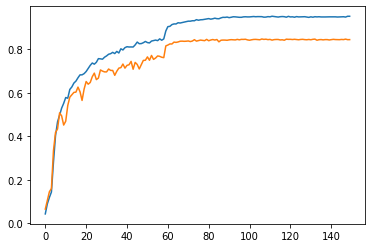

(0.8478, 0.5281801963806152)

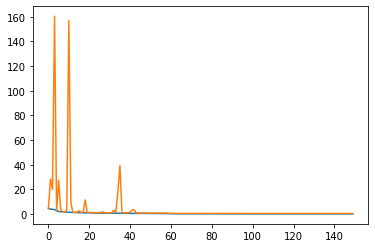

In [20]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])

best_acc, curloss

In [21]:
pickle.dump(hist, open('exploss_benchmarks/Resnet50_resExploss_CIFAR100_hist.hdf5', 'wb'))

# CIFAR 100 - ResNet18

In [26]:
class Resnet18_exp(nn.Module):
    def __init__(self, sample_model, in_features_classifier=2048, n_classes=100):
        super(Resnet18_exp, self).__init__()
        
        self.conv1 = sample_model.conv1
        self.bn1 = sample_model.bn1
        self.relu = sample_model.relu
        self.maxpool = sample_model.maxpool
        
        self.layer1 = sample_model.layer1
        self.layer2 = sample_model.layer2
        self.layer3 = sample_model.layer3
        self.layer4 = sample_model.layer4
        
        self.avgpool = sample_model.avgpool
        
        self.exploss = ExpLoss(in_features_classifier)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, n_classes))
                                        
    def forward(self, x, labels, return_att=True):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        att, sim_loss = self.exploss(x, labels)

        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

In [27]:
# create model
device = torch.device('cuda')
lr = 0.005
model = Resnet18_exp(sample_model=models.resnet18(pretrained=False), in_features_classifier=512, n_classes=100)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

In [28]:
model_path = 'exploss_benchmarks/Resnet18_resExploss_CIFAR100_model.pt'
epochs = 100
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/196 [00:00<?, ?it/s]

Epoch:  1


Loss=3.966198444366455 Batch_id=195 Accuracy=0.1125: 100%|██████████| 196/196 [00:19<00:00,  9.83it/s]     

- Avg.loss: 4.2581 | Avg.acc: 0.0670



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 3.6143 | Avg. test_acc: 0.1373
* Update optimal model
Epoch:  2


Loss=3.6175968647003174 Batch_id=195 Accuracy=0.2375: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]    

- Avg.loss: 3.0437 | Avg.acc: 0.2153


- Avg. test_loss: 2.7900 | Avg. test_acc: 0.2600


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=3.3223958015441895 Batch_id=195 Accuracy=0.1625: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s]    

- Avg.loss: 2.5151 | Avg.acc: 0.3177


- Avg. test_loss: 2.3804 | Avg. test_acc: 0.3532


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=3.0071213245391846 Batch_id=195 Accuracy=0.25: 100%|██████████| 196/196 [00:20<00:00,  9.73it/s]      

- Avg.loss: 2.2284 | Avg.acc: 0.3914


- Avg. test_loss: 2.2471 | Avg. test_acc: 0.3821


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=3.057965040206909 Batch_id=195 Accuracy=0.2125: 100%|██████████| 196/196 [00:20<00:00,  9.75it/s]     

- Avg.loss: 2.0164 | Avg.acc: 0.4378


- Avg. test_loss: 2.2576 | Avg. test_acc: 0.3828


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=2.6275694370269775 Batch_id=195 Accuracy=0.375: 100%|██████████| 196/196 [00:20<00:00,  9.73it/s]     

- Avg.loss: 1.8573 | Avg.acc: 0.4788


- Avg. test_loss: 1.9802 | Avg. test_acc: 0.4552


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=2.774130344390869 Batch_id=195 Accuracy=0.3: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]        

- Avg.loss: 1.7280 | Avg.acc: 0.5139


- Avg. test_loss: 1.7701 | Avg. test_acc: 0.5176


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=3.511173725128174 Batch_id=195 Accuracy=0.2625: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s]     

- Avg.loss: 1.6236 | Avg.acc: 0.5382



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 2.1162 | Avg. test_acc: 0.4770
Epoch:  9


Loss=3.2865939140319824 Batch_id=195 Accuracy=0.325: 100%|██████████| 196/196 [00:19<00:00,  9.86it/s]     

- Avg.loss: 1.5414 | Avg.acc: 0.5616



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.9166 | Avg. test_acc: 0.5032
Epoch:  10


Loss=2.3285346031188965 Batch_id=195 Accuracy=0.4: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]       

- Avg.loss: 1.4487 | Avg.acc: 0.5778


- Avg. test_loss: 1.5497 | Avg. test_acc: 0.5668


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=2.2857298851013184 Batch_id=195 Accuracy=0.4875: 100%|██████████| 196/196 [00:20<00:00,  9.80it/s]    

- Avg.loss: 1.3685 | Avg.acc: 0.6049


- Avg. test_loss: 1.5295 | Avg. test_acc: 0.5782


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=2.5501022338867188 Batch_id=195 Accuracy=0.4125: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]    

- Avg.loss: 1.3131 | Avg.acc: 0.6188



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.4981 | Avg. test_acc: 0.5769
Epoch:  13


Loss=3.207103729248047 Batch_id=195 Accuracy=0.3: 100%|██████████| 196/196 [00:19<00:00, 10.01it/s]        

- Avg.loss: 1.2644 | Avg.acc: 0.6345


- Avg. test_loss: 1.4100 | Avg. test_acc: 0.5968


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=2.985062837600708 Batch_id=195 Accuracy=0.3125: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]     

- Avg.loss: 1.2232 | Avg.acc: 0.6417


- Avg. test_loss: 1.4181 | Avg. test_acc: 0.6057


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=2.565603256225586 Batch_id=195 Accuracy=0.3625: 100%|██████████| 196/196 [00:20<00:00,  9.75it/s]     

- Avg.loss: 1.1899 | Avg.acc: 0.6546



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.3815 | Avg. test_acc: 0.5992
Epoch:  16


Loss=2.078538179397583 Batch_id=195 Accuracy=0.4125: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]     

- Avg.loss: 1.1472 | Avg.acc: 0.6664


- Avg. test_loss: 1.4048 | Avg. test_acc: 0.6109


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=2.050041437149048 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]     

- Avg.loss: 1.1471 | Avg.acc: 0.6659



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.5567 | Avg. test_acc: 0.5633
Epoch:  18


Loss=2.2130157947540283 Batch_id=195 Accuracy=0.4875: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]    

- Avg.loss: 1.1132 | Avg.acc: 0.6734


- Avg. test_loss: 1.1888 | Avg. test_acc: 0.6610


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.9277584552764893 Batch_id=195 Accuracy=0.4875: 100%|██████████| 196/196 [00:20<00:00,  9.74it/s]    

- Avg.loss: 1.1022 | Avg.acc: 0.6782



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2867 | Avg. test_acc: 0.6404
Epoch:  20


Loss=1.9375921487808228 Batch_id=195 Accuracy=0.525: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]     

- Avg.loss: 1.0568 | Avg.acc: 0.6858



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2351 | Avg. test_acc: 0.6510
Epoch:  21


Loss=2.3418235778808594 Batch_id=195 Accuracy=0.5125: 100%|██████████| 196/196 [00:19<00:00,  9.85it/s]    

- Avg.loss: 1.0420 | Avg.acc: 0.6934



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2852 | Avg. test_acc: 0.6348
Epoch:  22


Loss=2.083097457885742 Batch_id=195 Accuracy=0.5: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]        

- Avg.loss: 1.0231 | Avg.acc: 0.6992


- Avg. test_loss: 1.1610 | Avg. test_acc: 0.6650


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=2.4345028400421143 Batch_id=195 Accuracy=0.4625: 100%|██████████| 196/196 [00:20<00:00,  9.78it/s]    

- Avg.loss: 1.0103 | Avg.acc: 0.7033



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1762 | Avg. test_acc: 0.6646
Epoch:  24


Loss=1.720275640487671 Batch_id=195 Accuracy=0.5375: 100%|██████████| 196/196 [00:19<00:00,  9.82it/s]     

- Avg.loss: 0.9824 | Avg.acc: 0.7132



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1919 | Avg. test_acc: 0.6520
Epoch:  25


Loss=2.3556969165802 Batch_id=195 Accuracy=0.4875: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]       

- Avg.loss: 0.9790 | Avg.acc: 0.7116



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2388 | Avg. test_acc: 0.6515
Epoch:  26


Loss=2.8477511405944824 Batch_id=195 Accuracy=0.4125: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s]    

- Avg.loss: 0.9912 | Avg.acc: 0.7085


- Avg. test_loss: 1.1320 | Avg. test_acc: 0.6784


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=2.613154888153076 Batch_id=195 Accuracy=0.35: 100%|██████████| 196/196 [00:19<00:00,  9.93it/s]       

- Avg.loss: 0.9708 | Avg.acc: 0.7145


- Avg. test_loss: 1.1085 | Avg. test_acc: 0.6857


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=2.115410327911377 Batch_id=195 Accuracy=0.5125: 100%|██████████| 196/196 [00:19<00:00,  9.81it/s]     

- Avg.loss: 0.9532 | Avg.acc: 0.7170



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2759 | Avg. test_acc: 0.6410
Epoch:  29


Loss=1.9101518392562866 Batch_id=195 Accuracy=0.5: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s]       

- Avg.loss: 0.9352 | Avg.acc: 0.7273



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1462 | Avg. test_acc: 0.6648
Epoch:  30


Loss=2.611208438873291 Batch_id=195 Accuracy=0.425: 100%|██████████| 196/196 [00:19<00:00,  9.93it/s]      

- Avg.loss: 0.9304 | Avg.acc: 0.7243



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1050 | Avg. test_acc: 0.6824
Epoch:  31


Loss=1.9370914697647095 Batch_id=195 Accuracy=0.3875: 100%|██████████| 196/196 [00:19<00:00,  9.99it/s]    

- Avg.loss: 0.9273 | Avg.acc: 0.7286



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.1597 | Avg. test_acc: 0.6742
Epoch:  32


Loss=1.9802119731903076 Batch_id=195 Accuracy=0.475: 100%|██████████| 196/196 [00:20<00:00,  9.79it/s]     

- Avg.loss: 0.9128 | Avg.acc: 0.7312



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2252 | Avg. test_acc: 0.6569
Epoch:  33


Loss=1.6063880920410156 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]    

- Avg.loss: 0.9163 | Avg.acc: 0.7306



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 1.2323 | Avg. test_acc: 0.6553
Epoch    33: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  34


Loss=1.4473789930343628 Batch_id=195 Accuracy=0.5125: 100%|██████████| 196/196 [00:19<00:00,  9.86it/s]     

- Avg.loss: 0.7279 | Avg.acc: 0.7835


- Avg. test_loss: 0.8127 | Avg. test_acc: 0.7663


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=2.0696847438812256 Batch_id=195 Accuracy=0.4: 100%|██████████| 196/196 [00:19<00:00,  9.85it/s]        

- Avg.loss: 0.6496 | Avg.acc: 0.8070


- Avg. test_loss: 0.7715 | Avg. test_acc: 0.7797


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  36


Loss=1.5038906335830688 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s]     

- Avg.loss: 0.6219 | Avg.acc: 0.8134



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7794 | Avg. test_acc: 0.7740
Epoch:  37


Loss=1.3381893634796143 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:19<00:00,  9.95it/s]      

- Avg.loss: 0.6038 | Avg.acc: 0.8188



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7673 | Avg. test_acc: 0.7791
Epoch:  38


Loss=1.6238908767700195 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:19<00:00,  9.82it/s]      

- Avg.loss: 0.5823 | Avg.acc: 0.8265


- Avg. test_loss: 0.7509 | Avg. test_acc: 0.7807


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=1.6666091680526733 Batch_id=195 Accuracy=0.6: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]        

- Avg.loss: 0.5725 | Avg.acc: 0.8283


- Avg. test_loss: 0.7469 | Avg. test_acc: 0.7819


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=1.7436444759368896 Batch_id=195 Accuracy=0.575: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s]      

- Avg.loss: 0.5760 | Avg.acc: 0.8277


- Avg. test_loss: 0.7433 | Avg. test_acc: 0.7826


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=1.365262508392334 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]      

- Avg.loss: 0.5581 | Avg.acc: 0.8315


- Avg. test_loss: 0.7294 | Avg. test_acc: 0.7885


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=1.1838377714157104 Batch_id=195 Accuracy=0.725: 100%|██████████| 196/196 [00:19<00:00,  9.95it/s]      

- Avg.loss: 0.5515 | Avg.acc: 0.8347



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7300 | Avg. test_acc: 0.7852
Epoch:  43


Loss=1.3021892309188843 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]      

- Avg.loss: 0.5465 | Avg.acc: 0.8352



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7243 | Avg. test_acc: 0.7862
Epoch:  44


Loss=1.6183780431747437 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:19<00:00,  9.85it/s]      

- Avg.loss: 0.5339 | Avg.acc: 0.8402


- Avg. test_loss: 0.7127 | Avg. test_acc: 0.7941


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=1.4650311470031738 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:19<00:00,  9.90it/s]     

- Avg.loss: 0.5299 | Avg.acc: 0.8393



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7182 | Avg. test_acc: 0.7876
Epoch:  46


Loss=1.2903032302856445 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:19<00:00,  9.85it/s]       

- Avg.loss: 0.5210 | Avg.acc: 0.8435



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7110 | Avg. test_acc: 0.7929
Epoch:  47


Loss=1.1605334281921387 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]     

- Avg.loss: 0.5139 | Avg.acc: 0.8468



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7169 | Avg. test_acc: 0.7866
Epoch:  48


Loss=1.717821478843689 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:19<00:00,  9.83it/s]      

- Avg.loss: 0.5057 | Avg.acc: 0.8465



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7257 | Avg. test_acc: 0.7851
Epoch:  49


Loss=1.3841888904571533 Batch_id=195 Accuracy=0.55: 100%|██████████| 196/196 [00:19<00:00,  9.90it/s]       

- Avg.loss: 0.5144 | Avg.acc: 0.8452



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7100 | Avg. test_acc: 0.7905
Epoch:  50


Loss=1.402719497680664 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:19<00:00,  9.98it/s]        

- Avg.loss: 0.5010 | Avg.acc: 0.8472



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.7076 | Avg. test_acc: 0.7934
Epoch    50: reducing learning rate of group 0 to 5.0000e-05.
Epoch:  51


Loss=1.3581057786941528 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]     

- Avg.loss: 0.4775 | Avg.acc: 0.8557


- Avg. test_loss: 0.6894 | Avg. test_acc: 0.7959


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  52


Loss=1.4167699813842773 Batch_id=195 Accuracy=0.675: 100%|██████████| 196/196 [00:19<00:00,  9.81it/s]      

- Avg.loss: 0.4771 | Avg.acc: 0.8529


- Avg. test_loss: 0.6816 | Avg. test_acc: 0.8011


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  53


Loss=1.3708324432373047 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:19<00:00,  9.96it/s]      

- Avg.loss: 0.4706 | Avg.acc: 0.8608



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6907 | Avg. test_acc: 0.7962
Epoch:  54


Loss=1.7427351474761963 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]     

- Avg.loss: 0.4580 | Avg.acc: 0.8622



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6804 | Avg. test_acc: 0.7998
Epoch:  55


Loss=1.3613789081573486 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:19<00:00,  9.97it/s]       

- Avg.loss: 0.4594 | Avg.acc: 0.8596



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6863 | Avg. test_acc: 0.7951
Epoch:  56


Loss=1.6483474969863892 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]     

- Avg.loss: 0.4550 | Avg.acc: 0.8653



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6774 | Avg. test_acc: 0.8005
Epoch:  57


Loss=1.4711004495620728 Batch_id=195 Accuracy=0.5625: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]     

- Avg.loss: 0.4632 | Avg.acc: 0.8620



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6857 | Avg. test_acc: 0.7979
Epoch:  58


Loss=0.8697792291641235 Batch_id=195 Accuracy=0.75: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]       

- Avg.loss: 0.4587 | Avg.acc: 0.8612



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6753 | Avg. test_acc: 0.8004
Epoch    58: reducing learning rate of group 0 to 5.0000e-06.
Epoch:  59


Loss=1.1968379020690918 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:19<00:00,  9.86it/s]        

- Avg.loss: 0.4505 | Avg.acc: 0.8642



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6781 | Avg. test_acc: 0.7981
Epoch:  60


Loss=1.3484766483306885 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:19<00:00,  9.98it/s]        

- Avg.loss: 0.4661 | Avg.acc: 0.8613


- Avg. test_loss: 0.6750 | Avg. test_acc: 0.8016


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  61


Loss=1.1888883113861084 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]     

- Avg.loss: 0.4558 | Avg.acc: 0.8636


- Avg. test_loss: 0.6767 | Avg. test_acc: 0.8018


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  62


Loss=1.409447431564331 Batch_id=195 Accuracy=0.675: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]       

- Avg.loss: 0.4493 | Avg.acc: 0.8666



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6839 | Avg. test_acc: 0.7983
Epoch:  63


Loss=1.5779011249542236 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]     

- Avg.loss: 0.4650 | Avg.acc: 0.8590



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6800 | Avg. test_acc: 0.7996
Epoch:  64


Loss=1.0314115285873413 Batch_id=195 Accuracy=0.7: 100%|██████████| 196/196 [00:19<00:00,  9.97it/s]        

- Avg.loss: 0.4535 | Avg.acc: 0.8647



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6765 | Avg. test_acc: 0.8004
Epoch:  65


Loss=1.6800743341445923 Batch_id=195 Accuracy=0.625: 100%|██████████| 196/196 [00:19<00:00,  9.90it/s]      

- Avg.loss: 0.4552 | Avg.acc: 0.8635


- Avg. test_loss: 0.6713 | Avg. test_acc: 0.8023


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  69


Loss=1.3865578174591064 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]     

- Avg.loss: 0.4571 | Avg.acc: 0.8642



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6850 | Avg. test_acc: 0.7975
Epoch:  70


Loss=1.4141194820404053 Batch_id=195 Accuracy=0.6375: 100%|██████████| 196/196 [00:19<00:00,  9.85it/s]     

- Avg.loss: 0.4560 | Avg.acc: 0.8619



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6766 | Avg. test_acc: 0.7989
Epoch:  71


Loss=1.4655805826187134 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]     

- Avg.loss: 0.4499 | Avg.acc: 0.8676



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6749 | Avg. test_acc: 0.8022
Epoch:  72


Loss=1.2450661659240723 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]     

- Avg.loss: 0.4477 | Avg.acc: 0.8646



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6806 | Avg. test_acc: 0.7996
Epoch:  73


Loss=1.1138055324554443 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:19<00:00,  9.93it/s]     

- Avg.loss: 0.4526 | Avg.acc: 0.8637


- Avg. test_loss: 0.6733 | Avg. test_acc: 0.8028


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  74


Loss=1.6643257141113281 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:19<00:00,  9.90it/s]     

- Avg.loss: 0.4537 | Avg.acc: 0.8656



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6765 | Avg. test_acc: 0.7993
Epoch:  75


Loss=1.423398733139038 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:19<00:00, 10.03it/s]      

- Avg.loss: 0.4502 | Avg.acc: 0.8656



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6769 | Avg. test_acc: 0.8002
Epoch:  76


Loss=1.8769733905792236 Batch_id=195 Accuracy=0.5125: 100%|██████████| 196/196 [00:19<00:00,  9.83it/s]     

- Avg.loss: 0.4595 | Avg.acc: 0.8631



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6769 | Avg. test_acc: 0.8001
Epoch:  77


Loss=1.533673882484436 Batch_id=195 Accuracy=0.575: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]       

- Avg.loss: 0.4493 | Avg.acc: 0.8640



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6792 | Avg. test_acc: 0.7979
Epoch:  78


Loss=1.272478699684143 Batch_id=195 Accuracy=0.65: 100%|██████████| 196/196 [00:19<00:00,  9.86it/s]        

- Avg.loss: 0.4513 | Avg.acc: 0.8663



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6744 | Avg. test_acc: 0.8007
Epoch:  79


Loss=2.096526861190796 Batch_id=195 Accuracy=0.5: 100%|██████████| 196/196 [00:20<00:00,  9.79it/s]         

- Avg.loss: 0.4538 | Avg.acc: 0.8653



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6750 | Avg. test_acc: 0.8007
Epoch    79: reducing learning rate of group 0 to 5.0000e-08.
Epoch:  80


Loss=1.3400695323944092 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:19<00:00,  9.98it/s]     

- Avg.loss: 0.4505 | Avg.acc: 0.8646



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6800 | Avg. test_acc: 0.7989
Epoch:  81


Loss=1.0262362957000732 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]     

- Avg.loss: 0.4524 | Avg.acc: 0.8652



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6782 | Avg. test_acc: 0.7982
Epoch:  82


Loss=1.3187309503555298 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:19<00:00,  9.88it/s]     

- Avg.loss: 0.4599 | Avg.acc: 0.8633



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6752 | Avg. test_acc: 0.8011
Epoch:  83


Loss=1.6664165258407593 Batch_id=195 Accuracy=0.55: 100%|██████████| 196/196 [00:19<00:00,  9.90it/s]       

- Avg.loss: 0.4496 | Avg.acc: 0.8638


- Avg. test_loss: 0.6727 | Avg. test_acc: 0.8036


  0%|          | 0/196 [00:00<?, ?it/s]

* Update optimal model
Epoch:  84


Loss=1.0877875089645386 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:19<00:00,  9.95it/s]     

- Avg.loss: 0.4565 | Avg.acc: 0.8617



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6749 | Avg. test_acc: 0.8006
Epoch:  85


Loss=1.200494408607483 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:19<00:00,  9.99it/s]      

- Avg.loss: 0.4576 | Avg.acc: 0.8631



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6863 | Avg. test_acc: 0.7969
Epoch:  86


Loss=1.3200743198394775 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]     

- Avg.loss: 0.4538 | Avg.acc: 0.8625



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6754 | Avg. test_acc: 0.7992
Epoch:  87


Loss=1.259777307510376 Batch_id=195 Accuracy=0.675: 100%|██████████| 196/196 [00:20<00:00,  9.79it/s]       

- Avg.loss: 0.4582 | Avg.acc: 0.8638



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6771 | Avg. test_acc: 0.7996
Epoch:  88


Loss=1.4638025760650635 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s]     

- Avg.loss: 0.4496 | Avg.acc: 0.8654



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6755 | Avg. test_acc: 0.8023
Epoch:  89


Loss=1.104491949081421 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]      

- Avg.loss: 0.4487 | Avg.acc: 0.8665



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6784 | Avg. test_acc: 0.7970
Epoch    89: reducing learning rate of group 0 to 5.0000e-09.
Epoch:  90


Loss=0.8808611631393433 Batch_id=195 Accuracy=0.7375: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]     

- Avg.loss: 0.4541 | Avg.acc: 0.8643



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6785 | Avg. test_acc: 0.7998
Epoch:  91


Loss=1.3002420663833618 Batch_id=195 Accuracy=0.7125: 100%|██████████| 196/196 [00:19<00:00, 10.00it/s]     

- Avg.loss: 0.4599 | Avg.acc: 0.8618



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6733 | Avg. test_acc: 0.8016
Epoch:  92


Loss=1.8016273975372314 Batch_id=195 Accuracy=0.5875: 100%|██████████| 196/196 [00:19<00:00,  9.90it/s]     

- Avg.loss: 0.4534 | Avg.acc: 0.8638



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6743 | Avg. test_acc: 0.7993
Epoch:  93


Loss=0.80613774061203 Batch_id=195 Accuracy=0.7625: 100%|██████████| 196/196 [00:19<00:00,  9.87it/s]       

- Avg.loss: 0.4499 | Avg.acc: 0.8654



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6772 | Avg. test_acc: 0.7985
Epoch:  94


Loss=1.1046677827835083 Batch_id=195 Accuracy=0.6625: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s]     

- Avg.loss: 0.4508 | Avg.acc: 0.8634



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6763 | Avg. test_acc: 0.8009
Epoch:  95


Loss=1.0597087144851685 Batch_id=195 Accuracy=0.725: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]      

- Avg.loss: 0.4542 | Avg.acc: 0.8629



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6796 | Avg. test_acc: 0.8006
Epoch:  96


Loss=1.634523630142212 Batch_id=195 Accuracy=0.55: 100%|██████████| 196/196 [00:19<00:00,  9.88it/s]        

- Avg.loss: 0.4595 | Avg.acc: 0.8624



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6796 | Avg. test_acc: 0.8006
Epoch:  97


Loss=2.112215757369995 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s]      

- Avg.loss: 0.4625 | Avg.acc: 0.8622



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6724 | Avg. test_acc: 0.8035
Epoch:  98


Loss=1.0832253694534302 Batch_id=195 Accuracy=0.6875: 100%|██████████| 196/196 [00:19<00:00,  9.86it/s]     

- Avg.loss: 0.4576 | Avg.acc: 0.8606



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6748 | Avg. test_acc: 0.8012
Epoch:  99


Loss=1.273175597190857 Batch_id=195 Accuracy=0.675: 100%|██████████| 196/196 [00:19<00:00,  9.88it/s]       

- Avg.loss: 0.4568 | Avg.acc: 0.8617



  0%|          | 0/196 [00:00<?, ?it/s]

- Avg. test_loss: 0.6738 | Avg. test_acc: 0.7997
Epoch:  100


Loss=1.7216365337371826 Batch_id=195 Accuracy=0.6125: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s]     


- Avg.loss: 0.4599 | Avg.acc: 0.8613
- Avg. test_loss: 0.6702 | Avg. test_acc: 0.8030
